In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib as mpl
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.convolution.kernels import CustomKernel

import time

# from sklearn import gaussian_process
# from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

In [4]:
from scipy.interpolate import PchipInterpolator

In [5]:
# https://dsp.stackexchange.com/questions/1676/savitzky-golay-
#smoothing-filter-for-not-equally-spaced-data

def non_uniform_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing
    as defined in x

    This is based on https://dsp.stackexchange.com/questions/1676/
    savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

def find_runs(x):
    x = np.asanyarray(x)
    n = x.shape[0]
    
    # find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]

    # find run values
    run_values = x[loc_run_start]

    # find run lengths
    run_lengths = np.diff(np.append(run_starts, n))

    return run_values, run_starts, run_lengths

In [273]:
def decline_detection(data_frame,decline_min_depth=0.9,saturation_limit=12,
                      use_iter_smooth=False,debug_mode=False,iterate_depth=False,
                      plotfile=None,outfile=None):
    ##############################################
    ## note that the DataFrame must have a 'jd' column and a 'mag' column
    ##############################################

    ##############################################
    ## zeropoint so we don't have to do it forever
    ##############################################
    mjd_scale = data_frame['jd'][0]

    ##############################################
    ## apply a savgol filter to remove outliers
    ##############################################
    ### will fail if duplicate data points
    savgol_filtered = non_uniform_savgol(np.asarray(data_frame['jd']-mjd_scale),
                                         np.asarray(data_frame['mag']),
                                       window=7, polynom=1)
    
    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(data_frame['jd']-mjd_scale,data_frame['mag'],s=15,
                    c=savgol_filtered-data_frame['mag'],cmap='bwr',edgecolor='k',linewidth=0.5)
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('magnitude')
        plt.colorbar(label='savgol residual')
        plt.title('Savgol residual on original data')
        # plt.clim(vmax=-1)
        plt.clim(-1,1)
        plt.show()

    ## measure the std deviation of the savgol filtering
    ## we will kick out data points with residuals bigger than this
    deviation = np.std(savgol_filtered-data_frame['mag'])
    percentile = np.percentile(savgol_filtered-data_frame['mag'],95)
    percentile2 = np.percentile(savgol_filtered-data_frame['mag'],99)
    if debug_mode==True:
        print('Std dev:',deviation)
        print('95 percentile:',percentile)
        print('99 percentile:',percentile2)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(data_frame['jd']-mjd_scale,savgol_filtered-data_frame['mag'],s=10)
        plt.axhline(deviation,color='k',linestyle='--')
        plt.axhline(-deviation,color='k',linestyle='--')
        plt.axhline(percentile,color='red',linestyle='--')
        plt.axhline(-percentile,color='red',linestyle='--')
        plt.axhline(percentile2,color='green',linestyle='--')
        plt.axhline(-percentile2,color='green',linestyle='--')
        # plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('residuals to savgol filter')
        plt.title('savgol filter residuals with the cutoff labelled')
        plt.ylim(-1,1)
        plt.show()

    ## the actual mask for the savgol filtering
    mask = np.where(np.abs(savgol_filtered-data_frame['mag'])<percentile,True,False)
    ## add in a mask for bad measurements 1.5 mag above the saturation limit
    mask_satlim = np.where(data_frame['mag']<saturation_limit-1.5,False,True)
    mask = mask & mask_satlim

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(data_frame['jd'][mask]-mjd_scale,data_frame['mag'][mask],s=10)
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('magnitude')
        plt.title('Savgol filtered data')
        plt.show()

    ## apply the mask for savgol filtering
    savgol_filtered_frame = data_frame.iloc[mask]
    savgol_filtered_frame.reset_index(drop=True,inplace=True)
    # savgol_filtered_oband
    if savgol_filtered_frame['jd'][0] != mjd_scale:
        print('filtered first data point, resetting mjd_scale')
        mjd_scale = savgol_filtered_frame['jd'][0]

    ##############################################
    ## savgol filter to smooth the data
    ##############################################
    ## make another, more aggressive savgol filter to smooth the data
    iter_savgol_filtered = non_uniform_savgol(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                         np.asarray(savgol_filtered_frame['mag']),
                                       window=31, polynom=1)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],s=10,
                    c=iter_savgol_filtered-savgol_filtered_frame['mag'],cmap='bwr')
        plt.colorbar(label='iterated savgol residual')
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,iter_savgol_filtered,s=10,alpha=0.5,color='k')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('savgol filtered magnitude')
        plt.title('Savgol for smoothing (iter)')
        plt.show()

    ##############################################
    ## create a mask for the regions which are saturated
    ## this will need to be edited for things that aren't ATLAS
    ##############################################
    # I think we can use that ATLAS saturates at around 11 mag # r ~ 12.5
    # and limiting mag is ~20
    local_std = np.std((iter_savgol_filtered-savgol_filtered_frame['mag']))
#     saturation_limit = 0#12
    saturation_mask = []
#     variation_arr = []
    halfwidth=10
#     print('saturation_masking')
#     print('savgol length:',len(savgol_filtered_frame))
#     print('iter length:',len(iter_savgol_filtered))
    for i in range(0,len(savgol_filtered_frame)):
#         print(i)
        if i > int(len(savgol_filtered_frame)-halfwidth-1):
            saturation_mask.append(True)
#             print('end of array')
#             variation_arr.append(0)
        elif int(i < halfwidth):
            saturation_mask.append(True)
#             print('beginning of array')
#             variation_arr.append(0)
        else:
            variation_window = np.max(np.abs(iter_savgol_filtered[i-halfwidth:i+halfwidth]-savgol_filtered_frame['mag'][i-halfwidth:i+halfwidth]))
            time_res = savgol_filtered_frame['jd'][i+halfwidth] - savgol_filtered_frame['jd'][i-halfwidth]
            #             variation_arr.append(variation_window)
#             print('variation window',variation_window)
            if (variation_window > 0.1 and time_res < 50 and
                np.mean(savgol_filtered_frame['mag'][i-halfwidth:i+halfwidth])<saturation_limit):
#                 time_res = savgol_filtered_frame['jd'][i+halfwidth] - savgol_filtered_frame['jd'][i-halfwidth]
#                 print('time res', time_res)
        #         print('mask me')
                saturation_mask.append(False)
            else:
                saturation_mask.append(True)
#     variation_arr = np.asarray(variation_arr)
    saturation_mask = np.asarray(saturation_mask)

    if debug_mode==True:
#         plt.figure(figsize=(14,6))
#         plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],s=10,alpha=0.5)
#         plt.scatter(savgol_filtered_frame['jd'][saturation_mask]-mjd_scale,savgol_filtered_frame['mag'][saturation_mask],s=10,
#                     c=variation_arr[:-1],cmap='bwr')
#         # plt.scatter(savgol_filtered_frame['jd'][np.invert(saturation_mask)]-mjd_scale,
#         #            saturation_replace[np.invert(saturation_mask)],color='darkgrey')
#         plt.colorbar(label='variation window')
#         plt.clim(-0.5,0.5)
#         # plt.scatter(savgol_filtered_frame['jd']-mjd_scale,iter_savgol_filtered,s=10,alpha=0.5)
#         plt.gca().invert_yaxis()
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('savgol filtered magnitude')
#         plt.title('checking the variation window argument for saturation masking')
#         # plt.colorbar(label='iterated savgol residual')
#         # plt.clim(vmax=-1)
#         # plt.clim(vmin=-2)
#         plt.show()
        
        
        plt.figure(figsize=(14,6))
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],s=10,alpha=0.5)
        plt.scatter(savgol_filtered_frame['jd'][saturation_mask]-mjd_scale,savgol_filtered_frame['mag'][saturation_mask],s=10,
                    c=iter_savgol_filtered[saturation_mask]-savgol_filtered_frame['mag'][saturation_mask],cmap='bwr')
        plt.colorbar(label='iterated savgol residual')
        plt.clim(-1,1)
        plt.scatter(savgol_filtered_frame['jd'][~saturation_mask]-mjd_scale,savgol_filtered_frame['mag'][~saturation_mask],
                    s=10,color='k')
        # plt.scatter(savgol_filtered_frame['jd'][np.invert(saturation_mask)]-mjd_scale,
        #            saturation_replace[np.invert(saturation_mask)],color='darkgrey')
        # plt.scatter(savgol_filtered_frame['jd']-mjd_scale,iter_savgol_filtered,s=10,alpha=0.5)
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('savgol filtered magnitude')
        # plt.colorbar(label='iterated savgol residual')
#         plt.clim(vmin=-2)
        plt.show()



    ##############################################
    ## decide on the iter smooth or the original data
    ##############################################
    if use_iter_smooth==True:
        ## make another, more aggressive savgol filter to smooth the data
        iter_savgol_filtered = non_uniform_savgol(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                             np.asarray(savgol_filtered_frame['mag']),
                                           window=7, polynom=1)


    ##############################################
    ## interpolate the data to get evenly sampled data
    ##############################################
    if use_iter_smooth==True:
        interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                                         np.asarray(iter_savgol_filtered),
                                                         kind='linear')
    else:
        interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                                         np.asarray(savgol_filtered_frame['mag']),
                                                         kind='linear')

    ### attempting monotone interpolants ###
    # interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
    #                                                  np.asarray(iter_savgol_filtered)) # this one is better
    # interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
    #                                                  np.asarray(savgol_filtered_frame['mag'])) # this one is better


    ## what time resolution? I don't want to lose any of the real data if possible
    real_resolution = np.average(np.diff(savgol_filtered_frame['jd']))
    if debug_mode==True:
        print('data resolution:', real_resolution)
    len_data = np.max(savgol_filtered_frame['jd']-mjd_scale)
    resample_time = np.linspace(0,len_data,int(len_data)) # declines don't matter closer than this
    ## currently resampling at a resolution of 1 day
    resample_flux = interpolation_function(resample_time)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10)
        plt.scatter(np.asarray(savgol_filtered_frame['jd']-mjd_scale),np.asarray(iter_savgol_filtered),s=10)
        plt.scatter(np.asarray(savgol_filtered_frame['jd']-mjd_scale),np.asarray(savgol_filtered_frame['mag']),s=10)
        plt.gca().invert_yaxis()
        plt.xlabel('resampled jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.title('checking the interpolation method with the smooth/orig data')
        # plt.ylim(20.5,11)
        # plt.ylim(14,11)
        # plt.xlim(1000,1200)
        plt.show()

#     ##############################################
#     ## edge detection via convolution - this is identical to gradient but slower
#     ##############################################
#     start = time.time()
#     new_edge_detect = sp.ndimage.convolve(resample_flux, [1.0, 0.0, -1.0])
#     end = time.time()
#     print('convolution edges time:', end - start)

#     if debug_mode==True:
#         plt.figure(figsize=(14,6))
#         plt.scatter(resample_time,new_edge_detect,s=10)
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('edge detection')
#         plt.title('edge detection via convolution')
#         # plt.ylim(-1,1)
#         plt.show()

#         plt.figure(figsize=(14,6))
#         # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
#         plt.scatter(resample_time,resample_flux,s=10,
#                     c=new_edge_detect,cmap='bwr')#,alpha=0.2)
#         # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
#         plt.gca().invert_yaxis()
#         plt.xlabel('resampled jd - '+str(mjd_scale))
#         plt.ylabel('interpolated magnitude')
#         plt.colorbar(label='edge detect')
#         plt.clim(-0.1,0.1)
#         plt.title('plotting edge detection via convolution on the original data')
#         plt.show()

#     ##############################################
#     ## creating a mask for when edge detect is positive
#     ##############################################
#     # std_dev = np.std(new_edge_detect)
#     # # std_dev
#     # new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
#     new_mask = np.where(np.abs(new_edge_detect)>0,True,False)

#     if debug_mode==True:
#         plt.figure(figsize=(14,6))
#         # plt.scatter(data_frame['jd'][mask]-mjd_scale,(gp_edges+3)*4,s=10)
#         plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
#         plt.scatter(resample_time[new_mask],resample_flux[new_mask],s=10,
#                     c=new_edge_detect[new_mask],cmap='bwr')
#         plt.gca().invert_yaxis()
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('interpolated magnitude')
#         plt.colorbar(label='edge detect')
#         plt.title('positive in edge detection via convolution')
#         plt.clim(-0.1,0.1)
#         # plt.xlim(950,1200)
#         # plt.xlim(500,1000)
#         plt.show()

#     ##############################################
#     ## create mask for edge detection significantly positive
#     ##############################################
#     std_dev = np.std(new_edge_detect)
#     new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
#     downslope_mask = np.where(new_edge_detect>0.0,True,False)
#     total_mask = new_mask & downslope_mask

#     if debug_mode==True:
#         plt.figure(figsize=(14,6))
#         # plt.scatter(data_frame['jd'][mask]-mjd_scale,(gp_edges+3)*4,s=10)
#         plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
#         plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
#                     c=new_edge_detect[total_mask],cmap='bwr')
#         plt.gca().invert_yaxis()
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('interpolated magnitude')
#         plt.title('masked for edge detection significantly positive')
#         plt.colorbar(label='edge detect')
#         plt.clim(-0.1,0.1)
#         # plt.xlim(950,1200)
#         # plt.xlim(500,1000)
#         plt.show()

    ##############################################
    ## edge detection via gradients
    ##############################################
#     start = time.time()
    gradient = np.gradient(resample_flux, resample_time)
    smooth_gradient = non_uniform_savgol(resample_time,
                                        gradient,
                                        window=7, polynom=1)
#     smooth_gradient = convolve(gradient, Box1DKernel(7))
    second_gradient = np.gradient(smooth_gradient, resample_time)
#     end = time.time()
#     print('gradient edges time:', end - start)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,gradient,s=10)
        plt.axhline(0.0,color='k',linestyle='--')
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('gradient')
        plt.title('the gradient')
        plt.ylim(-0.25,0.25)
        plt.show()
        
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,smooth_gradient,s=10)
        plt.axhline(0.0,color='k',linestyle='--')
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('smooth gradient')
        plt.title('the smoothed gradient')
        plt.ylim(-0.25,0.25)
        plt.show()
        
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,second_gradient,s=10)
        plt.axhline(0.0,color='k',linestyle='--')
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('second gradient')
        plt.title('the second gradient')
#         plt.ylim(-0.25,0.25)
        plt.show()

#         plt.figure(figsize=(14,6))
#         plt.scatter(resample_time,(gradient/np.max(gradient))-(new_edge_detect/np.max(new_edge_detect)),s=10)
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('diff between gradient and convolution edges')
#         plt.ylim(-0.25,0.25)
#         plt.show()

        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,
                    c=gradient,cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.title('edge detection via the gradient')
        plt.clim(-0.1,0.1)
        plt.show()
        
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,
                    c=smooth_gradient,cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='smooth gradient')
        plt.title('edge detection via the smoothed gradient')
        plt.clim(-0.1,0.1)
        plt.show()
        
#         plt.figure(figsize=(14,6))
#         plt.scatter(resample_time,gradient,s=15,
#                     c=second_gradient,cmap='bwr',edgecolor='k',linewidth=0.5)
# #         plt.gca().invert_yaxis()
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('gradient')
#         plt.colorbar(label='second gradient')
#         plt.title('gradient with the second gradient')
#         plt.clim(-0.1,0.1)
#         plt.xlim(1500,2000)
#         plt.show()

    ##############################################
    ## mask for where gradient is positive
    ##############################################
    downslope_mask = np.where(smooth_gradient>0,True,False)
#     downslope_mask = np.where(gradient>0,True,False)
    total_mask = downslope_mask

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[downslope_mask],resample_flux[downslope_mask],s=10,
                    c=gradient[downslope_mask],cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.title('positive gradient mask')
        plt.clim(-0.1,0.1)
        plt.show()
        
        
    ##############################################
    ## recalculate the minimum detectable decline depth
    ##############################################
    if iterate_depth == True:
        max_light_region = np.where(savgol_filtered_frame['mag']<np.min(savgol_filtered_frame['mag']+decline_min_depth),True,False)
        max_light_val_mean = np.average(savgol_filtered_frame['mag'][max_light_region])
        max_light_deviation = np.std(savgol_filtered_frame['mag'][max_light_region])
        sigma = 1.5
        print('new detectable decline depth:',np.round(max_light_deviation*sigma*2,2))
        decline_min_depth = np.round(max_light_deviation*sigma*2,2)
    

    ##############################################
    ## find the runs of positive and negative values
    ##############################################
    run_vals, run_start, run_length = find_runs(total_mask)

    downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
    upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

    ## generation of the actual decline onsets
    ## this is the meat of the code
    if debug_mode==True:
        print('actually detecting the declines')
#     decline_min_depth = 0.9
    decline_onset = []
    decline_end = []
    decline_depth = []
    for i in range(0,len(resample_flux[run_start])):
        ####################################################################
        if i == 0 and resample_flux[0] > (np.min(resample_flux)+decline_min_depth):
            # and np.abs(resample_flux[0] - resample_flux[run_start[i+1]]) > decline_min_depth:
            ## two possible cases: either starts going down or starts going up
            ## either way, they should BOTH start below the decline threshold
            ## adding the absolute magnitude should detect beginning declines
            ## NEEDS TO BE TESTED - has been tested a little bit, needs more
            decline_onset.append(0)
            if debug_mode==True:
                print('beginning i=0')
                print(resample_flux[0])
#                 print(np.abs(resample_flux[0] - resample_flux[run_start[i]]))
            decline_end.append(run_start[i+1])
            decline_depth.append(np.abs(resample_flux[0] - resample_flux[run_start[i+1]]))
            ####################################################################
        elif i == len(resample_flux[run_start])-1:
            if resample_flux[-1] - resample_flux[run_start[i]] > decline_min_depth:
                decline_onset.append(run_start[i])
                if debug_mode==True:
                    print('end')
                    print(run_start[i])
                    print(resample_flux[run_start[i]])
                    print(resample_flux[-1] - resample_flux[run_start[i]])
                decline_end.append(len(resample_flux)-1)
                decline_depth.append(resample_flux[-1] - resample_flux[run_start[i]])
        elif resample_flux[run_start[i+1]] - resample_flux[run_start[i]] > decline_min_depth:#1:
            decline_onset.append(run_start[i])
            if debug_mode==True:
                print(run_start[i])
                print(resample_flux[run_start[i]])
                print(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
            decline_end.append(run_start[i+1])
            decline_depth.append(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
    #     if i == len(resample_flux[run_start]):
    #         print('end')
    if debug_mode==True:
        print(resample_flux[decline_end])
        print(decline_depth)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[downward_mask],
                    np.full(len(resample_time[downward_mask]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='k',zorder=3)
        plt.scatter(resample_time[upward_mask],
                    np.full(len(resample_time[upward_mask]),np.min(resample_flux))-0.2,
                            s=20,marker='x',color='tab:green',zorder=3)
        plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
                    c=(gradient[total_mask]),cmap='bwr')

        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.clim(-0.1,0.1)
        plt.title('all the original run masks')
        plt.show()

        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[decline_onset],
                    np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
                            s=20,marker='x',color='k',zorder=3)
        plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
                    c=(gradient[total_mask]),cmap='bwr')

        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.title('the better run masks with the gradient mask')
        plt.clim(-0.1,0.1)
        plt.show()

    ## more of the meat here
    ## turning the masks into real data points
    plt.figure(figsize=(14,6))
    plt.scatter(resample_time,resample_flux,s=10,color='lightsteelblue')
    plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],
                s=10,color='darkgrey')
    plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
                c=(gradient[total_mask]),cmap='bwr',alpha=0.2)
    plt.clim(-0.1,0.1)

    onset_arr = []
    onset_flag = []
    max_depth_arr = []
    end_arr = []
    end_flag = []

    max_light = np.min(resample_flux)
    plt.axhline(max_light,color='k',linestyle='--')
    plt.axhline(max_light+decline_min_depth,color='k',linestyle='--',alpha=0.5)
    for i in range(0,len(resample_time[decline_onset])):
        flag_set = False
        if decline_onset[i] == 0:
    #         print('beginning of array')
            onset_flag.append(1)
            flag_set = True
        onset_time = resample_time[decline_onset][i]
        diff_arr = np.abs((savgol_filtered_frame['jd'][saturation_mask]-mjd_scale)-onset_time)
        diff_arr_normal = np.abs((savgol_filtered_frame['jd']-mjd_scale)-onset_time)
#         if debug_mode == True:
#             print('min diff_arr',np.min(diff_arr))
#             print('min diff_arr_normal',np.min(diff_arr_normal))
        if np.min(diff_arr) > 5:
            if decline_depth[i] > decline_min_depth+1:#12-np.min(savgol_filtered_frame['mag']):
                plt.axvline(onset_time,color='red',linestyle='--')
                plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
    #             plt.axhline(max_light+decline_min_depth+decline_depth[i],color='k',linestyle='--')
                onset_arr.append(onset_time)
                max_depth_arr.append(resample_time[decline_end[i]])
                if flag_set == False:
                    onset_flag.append(2)
    #             print('onset', onset_time)
            else:
                if debug_mode == True:
                    print('bad onset')
                plt.axvline(onset_time,color='k',linestyle='--')
                onset_flag.append(3)
                onset_arr.append(onset_time)
                max_depth_arr.append(resample_time[decline_end[i]])
                pass
    #             plt.axvline(onset_time,color='red',linestyle='--')
        else:
            plt.axvline(onset_time,color='green',linestyle='--',alpha=0.5)
            plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
    #         plt.axhline(max_light+decline_min_depth+decline_depth[i],linestyle='--')
            if flag_set == False:
                onset_flag.append(0)
            onset_arr.append(onset_time)
            max_depth_arr.append(resample_time[decline_end[i]])
    #         print('onset', onset_time)

        post_decline_time = resample_time[resample_time>onset_time]
        post_decline_flux = resample_flux[resample_time>onset_time]
        xx = 0
        while post_decline_flux[xx] < (max_light+decline_min_depth):
            xx=xx+1
        else:
    #         print('exited max light')
            exit_time = post_decline_time[xx]
            post_decline_time = resample_time[resample_time>exit_time]
            post_decline_flux = resample_flux[resample_time>exit_time]

        xx = 0
        try:
            while post_decline_flux[xx] > (max_light+decline_min_depth):
                xx=xx+1
            else:
    #             print('reached max light')
    #             print(xx,post_decline_flux[xx],post_decline_time[xx])
                if onset_flag[-1] != 3:
                    plt.axvline(post_decline_time[xx],color='blue',linestyle='--',alpha=0.5)
                end_arr.append(post_decline_time[xx])
                end_flag.append(0)
        except IndexError:
    #         print('reached end of array')
    #         print(xx-1,post_decline_flux[xx-1],post_decline_time[xx-1])
            if onset_flag[-1] != 3:
                plt.axvline(post_decline_time[xx-1],color='blue',linestyle='--',alpha=0.5)
            end_arr.append(post_decline_time[xx-1])
            end_flag.append(1)

    # print(onset_arr)
    # print(onset_flag)
    # print(end_arr)
    # print(end_flag)
    # print(max_depth_arr)

    plt.scatter(resample_time[decline_onset][np.asarray(onset_flag) != 3],
                np.full(len(resample_time[decline_onset][np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.2,
                        s=20,marker='x',color='k',zorder=3)

    for i in range(0,len(onset_arr)):
        if onset_flag[i] != 3:
            plt.axvspan(onset_arr[i], end_arr[i], alpha=0.1, color='grey')

    plt.gca().invert_yaxis()
    plt.xlabel('jd - '+str(mjd_scale))
    plt.ylabel('savgol filtered magnitude')
    plt.title('setting the onsets and the flags')
    plt.show()

    ## resample the times back to the original data set
    orig_time = savgol_filtered_frame['jd']-mjd_scale
#     print('onsets')
    onset_arr_orig = return_arr_to_orig(onset_arr,orig_time,savgol_filtered_frame['mag'],
                                        onset_flag,arr_type='onset')
#     print('ends')
    end_arr_orig = return_arr_to_orig(end_arr,orig_time,savgol_filtered_frame['mag'],
                                      onset_flag,arr_type='end')
    depth_time_orig = return_arr_to_orig(max_depth_arr,orig_time,savgol_filtered_frame['mag'],
                                         onset_flag,arr_type='depth')

    ## calculate errors
    onset_err_arr_l,onset_err_arr_r = err_calculation(onset_arr_orig,orig_time)
    end_err_arr_l,end_err_arr_r = err_calculation(end_arr_orig,orig_time)
    depth_err_arr_l,depth_err_arr_r = err_calculation(depth_time_orig,orig_time)
    
    ##############################################
    ## check if there are actually any declines
    ##############################################
    if len(onset_arr_orig) == 0:
        print('no declines')
        
        ## plot the light curve
        plt.figure(figsize=(14,6))
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],
                    s=10,color='darkgrey')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('savgol filtered magnitude')
        if plotfile != None:
            plt.title(plotfile)
            plt.savefig(plotfile,bbox_inches='tight',dpi=300)
        plt.title('no declines')
        plt.show()
        
        
        return np.nan
    
    
    ##############################################
    ## refine the decline onset calculation
    ##############################################
    (new_onset_arr_orig,
    new_onset_err_arr_l,
    new_onset_err_arr_r)= refine_onset_times(onset_arr_orig,
                                           onset_flag,
                                           resample_time,
                                           resample_flux,
                                           orig_time,
                                           savgol_filtered_frame['mag'],
                                           smooth_gradient,second_gradient,
                                           debug_mode=debug_mode)

    ## the original ones are better 
    ## (but I still want to see the refining plots in debug mode)
    new_onset_arr_orig = onset_arr_orig
    new_onset_err_arr_l = onset_err_arr_l
    new_onset_err_arr_r = onset_err_arr_r
    
#     print(onset_arr)
#     print(onset_arr_orig)
#     print(new_onset_arr_orig)
    
    
    ##############################################
    ## refine the decline minima
    ##############################################
    (new_depth_time_orig,
     new_depth_err_arr_l,
     new_depth_err_arr_r,
     new_decline_depth,
     new_decline_min_mag,
     onset_flag) = refine_decline_minima(new_onset_arr_orig,
                                         onset_flag,
                                         end_arr_orig,
                                         resample_time,
                                         resample_flux,
                                         orig_time,
                                         savgol_filtered_frame['mag'],
                                         decline_min_depth=decline_min_depth,
                                         debug_mode=debug_mode)

    ##############################################
    ## check the number of points in the decline
    ##############################################
    sampling_arr = []
    for i in range(0,len(new_onset_arr_orig)):
        decline_region = np.where(np.logical_and(orig_time>=new_onset_arr_orig[i],
                                                 orig_time<=end_arr_orig[i]),True,False)
        if i != (len(new_onset_arr_orig)-1):
            nested_region = np.where(np.logical_and(orig_time>=new_onset_arr_orig[i],
                                                     orig_time<=new_onset_arr_orig[i+1]),True,False)
            decline_region = decline_region & nested_region
#         baseline = np.asarray(orig_time[decline_region])[-1]-np.asarray(orig_time[decline_region])[0]
#         print('decline',i,'length',len(orig_time[decline_region]),'time',baseline)
#         sampling = (len(orig_time[decline_region])/baseline)
#         print('sampling with n of points:',sampling,'(n of points per day)')
        nof_days_decline = len(np.unique(np.floor(np.asarray(orig_time[decline_region]))))
#         print('nof_days decline',nof_days_decline)
        decline_arr = np.arange(np.floor(np.asarray(orig_time[decline_region])[0]),
                                np.ceil(np.asarray(orig_time[decline_region])[-1]))
#         print('nof_days whole decline',len(decline_arr))
#         print(decline_arr)
#         print(np.setdiff1d(decline_arr,np.unique(np.floor(np.asarray(orig_time[decline_region])))))
#         print('n of days without data:',len(np.setdiff1d(decline_arr,np.unique(np.floor(np.asarray(orig_time[decline_region]))))))
        percent_data = np.round((100*nof_days_decline/len(decline_arr)),2)
#         print('percent of days with data:',percent_data)
#         print('------------------------------------------------')
        sampling_arr.append(percent_data)
    sampling_arr = np.asarray(sampling_arr)

#     max_light_region = np.where(savgol_filtered_frame['mag']<np.min(savgol_filtered_frame['mag']+decline_min_depth),True,False)
#     max_light_val_mean = np.average(savgol_filtered_frame['mag'][max_light_region])
#     max_light_deviation = np.std(savgol_filtered_frame['mag'][max_light_region])
#     print('new detectable decline depth:',max_light_deviation*sigma*2)
    
    ## plot the errorbars
    plt.figure(figsize=(14,6))
    plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],
                s=10,color='darkgrey')
    
#     plt.axhline(max_light_val_mean+max_light_deviation*sigma,color='blue',linestyle='--')
#     plt.axhline(max_light_val_mean-max_light_deviation*sigma,color='blue',linestyle='--')

    plt.errorbar(x=new_onset_arr_orig[np.asarray(onset_flag) != 3],
                y=np.full(len(new_onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
                 xerr=(new_onset_err_arr_l[np.asarray(onset_flag) != 3],
                       new_onset_err_arr_r[np.asarray(onset_flag) != 3]),fmt='o')

    plt.errorbar(x=end_arr_orig[np.asarray(onset_flag) != 3],
                y=np.full(len(end_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0,
                 xerr=(end_err_arr_l[np.asarray(onset_flag) != 3],
                       end_err_arr_r[np.asarray(onset_flag) != 3]),fmt='o')

    plt.errorbar(x=new_depth_time_orig[np.asarray(onset_flag) != 3],
                y=np.full(len(new_depth_time_orig[np.asarray(onset_flag) != 3]),np.max(resample_flux))+0.4,
                 xerr=(new_depth_err_arr_l[np.asarray(onset_flag) != 3],
                       new_depth_err_arr_r[np.asarray(onset_flag) != 3]),fmt='o')


    for onset_time in new_onset_arr_orig[np.asarray(onset_flag) != 3]:
        plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')

    for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
        plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')

    for i in range(0,len(new_onset_arr_orig)):
        if onset_flag[i] != 3:
            plt.axvspan(new_onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')

    plt.gca().invert_yaxis()
    plt.xlabel('jd - '+str(mjd_scale))
    plt.ylabel('savgol filtered magnitude')
    if plotfile != None:
        plt.title(plotfile)
        plt.savefig(plotfile,bbox_inches='tight',dpi=300)
    plt.title('showing the errors on the all of the times')
    plt.show()

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,smooth_gradient,s=10,color='tab:red')
        plt.scatter(new_onset_arr_orig[np.asarray(onset_flag) != 3],
                    np.full(len(new_onset_arr_orig[np.asarray(onset_flag) != 3]),0),
                            s=20,marker='x',color='k',zorder=3)

        plt.errorbar(x=new_onset_arr_orig[np.asarray(onset_flag) != 3],
                    y=np.full(len(new_onset_arr_orig[np.asarray(onset_flag) != 3]),0),
                     xerr=(new_onset_err_arr_l[np.asarray(onset_flag) != 3],
                           new_onset_err_arr_r[np.asarray(onset_flag) != 3]),fmt='o')

        for onset_time in new_onset_arr_orig[np.asarray(onset_flag) != 3]:
            plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')
        for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
            plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')

        for i in range(0,len(new_onset_arr_orig)):
            if onset_flag[i] != 3:
                plt.axvspan(new_onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')
                
        plt.axhline(0.0,color='k',linestyle='--')

        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('smoothed gradient')
        plt.title('the gradient and the errors')
        plt.show()

    ##############################################
    ## save all the data in a dataframe
    ##############################################
#     decline_arr = np.array([onset_arr_orig,onset_err_arr,onset_flag,
#                             end_arr_orig,end_err_arr,end_flag,
#                             depth_time_orig,depth_err_arr,
#                             decline_depth,resample_flux[decline_end]])
    decline_arr = np.array([new_onset_arr_orig+mjd_scale,
                            new_onset_err_arr_l,new_onset_err_arr_r,
                            onset_flag,
                            end_arr_orig+mjd_scale,
                            end_err_arr_l,end_err_arr_r,
                            end_flag,
                            new_depth_time_orig+mjd_scale,
                            new_depth_err_arr_l,new_depth_err_arr_r,
                            new_decline_depth,
                            new_decline_min_mag,
                            sampling_arr])
    decline_frame = pd.DataFrame(decline_arr.T,
                                 columns=['onset_time','onset_err_l','onset_err_r','onset_flag',
                                          'end_time','end_err_l','end_err_r','end_flag',
                                          'depth_time','depth_err_l','depth_err_r','decline_depth',
                                          'min_mag','sampling'])
    if debug_mode==True:
        print(decline_frame)
        
    ##############################################
    ## calculate some global values for return
    ##############################################
    nof_days_obs = len(np.unique(np.floor(np.asarray(orig_time))))
    obs_arr = np.arange(np.floor(np.asarray(orig_time)[0]),
                            np.ceil(np.asarray(orig_time)[-1]))
    percent_obs = np.round((100*nof_days_obs/len(obs_arr)),2)
        
    max_light_region = np.where(savgol_filtered_frame['mag']<np.min(savgol_filtered_frame['mag']+decline_min_depth),True,False)
    max_light_val_median = np.round(np.median(savgol_filtered_frame['mag'][max_light_region]),3)
    max_light_val_mean = np.round(np.average(savgol_filtered_frame['mag'][max_light_region]),3)
    print('median max light:',max_light_val_median)
    print('mean max light:',max_light_val_mean)
    print('min decline depth:',decline_min_depth)
    baseline = np.asarray(savgol_filtered_frame['jd'])[-1]-np.asarray(savgol_filtered_frame['jd'])[0]
    print('length of light curve:',baseline)
    print('sampling percent of light curve:',percent_obs)
    
    ## add the global values as metadata in the pandas frame
    ## dangerous since attrs is experimental
    decline_frame.attrs = {'median_max':max_light_val_median,
                          'mean_max':max_light_val_mean,
                          'min_depth':decline_min_depth,
                          'baseline':baseline,
                          'sampling':percent_obs}
    print(decline_frame.attrs)
    if outfile != None:
        with pd.HDFStore(outfile) as hdf_store:
            hdf_store.put('data', decline_frame, format='table')
            hdf_store.get_storer('data').attrs.metadata = decline_frame.attrs
    
    return decline_frame

In [274]:
def return_arr_to_orig(time_array,orig_time,orig_flux,arr_flag,arr_type):
    return_arr = []
    width=10
    real_res = np.average(np.diff(orig_time))
#     orig_time = savgol_filtered_oband['mjd']-mjd_scale
    for i in range(0,len(time_array)):#datapt in time_array:
        matched_time_ind = np.argmin(np.abs(orig_time-time_array[i]))
#         if (arr_type == 'onset' and 
#             (orig_flux[matched_time_ind+width]<(np.min(orig_flux)+decline_min_depth)) and 
#             (orig_flux[matched_time_ind]<(np.min(orig_flux)+decline_min_depth)) and
#             arr_flag[i]!=3):
# #             print('matched_time_ind',matched_time_ind)
# #             print('around there',orig_time[matched_time_ind:matched_time_ind+width])
# #             print('gap size ',real_res*6)
#             if (orig_time[matched_time_ind+width] - orig_time[matched_time_ind]) > real_res*6:
# #                 print('decline',i,'big gap, changing index')
#                 xx = 1
#                 ## find where the jump is
#                 while (orig_time[matched_time_ind+xx]-orig_time[matched_time_ind])<real_res*6:
# #                     print(xx,'still small')
#                     xx=xx+1
# #                 print(np.diff(orig_time[matched_time_ind:matched_time_ind+width]))
#                 matched_time_ind = matched_time_ind+xx
#         elif arr_type == 'end':
# #             print('matched_time_ind',matched_time_ind)
# #             print('around there',orig_time[matched_time_ind-5:matched_time_ind+5])
# #             print('gap size ',real_res*6)
#             if (orig_time[matched_time_ind] - orig_time[matched_time_ind-5]) > real_res*6:
#                 print('big gap')
        return_arr.append(orig_time[matched_time_ind])
    return_arr = np.asarray(return_arr)
    return return_arr

def err_calculation(time_arr,orig_time):
    width = 10
    err_arr_l = []
    err_arr_r = []
    for time in time_arr:
        matched_time_ind = np.argmin(np.abs(orig_time-time))
        if matched_time_ind == 0 or matched_time_ind < width: # if at beginning of array
            err_arr_l.append(np.nan)
            err_arr_r.append((orig_time[matched_time_ind+width]-orig_time[matched_time_ind])/2)
        elif matched_time_ind > (len(orig_time)-1-width): # if at end of array
            err_arr_l.append((orig_time[matched_time_ind]-orig_time[matched_time_ind-width])/2)
            err_arr_r.append(np.nan)
        else: # all the other points
            err_arr_l.append((orig_time[matched_time_ind]-orig_time[matched_time_ind-width])/2)
            err_arr_r.append((orig_time[matched_time_ind+width]-orig_time[matched_time_ind])/2)
    err_arr_l = np.asarray(err_arr_l)
    err_arr_r = np.asarray(err_arr_r)
    return err_arr_l,err_arr_r

In [275]:
def refine_decline_minima(onset_array,onset_flag_arr,end_array,interp_time,interp_flux,orig_time,orig_flux,
                          decline_min_depth,debug_mode=False):
    depth_arr = []
    decline_min_mag = []
    decline_depth = []
    if debug_mode == True:
        f,ax = plt.subplots(int(np.ceil(len(onset_array)/4)), 4,
                            figsize=(13,4*np.ceil(len(onset_array)/4)))
    for i in range(0,len(onset_array)):
        decline_region = np.where(np.logical_and(interp_time>=onset_array[i],
                                                 interp_time<=end_array[i]),True,False)
        if i != (len(onset_array)-1):
            nested_region = np.where(np.logical_and(interp_time>=onset_array[i],
                                                     interp_time<=onset_array[i+1]),True,False)
            decline_region = decline_region & nested_region
#             peaks, prop = sp.signal.find_peaks(interp_flux[decline_region],prominence=(0.5))
#             print(prop['prominences'])
        simple_peak = np.argmax(interp_flux[decline_region])
        depth_arr.append(interp_time[decline_region][simple_peak])
#         decline_min_mag.append(interp_flux[decline_region][simple_peak])
        if onset_flag_arr[i]==1: ## if the onset is the beginning of the data
            depth = interp_flux[decline_region][simple_peak] - (np.min(interp_flux)+decline_min_depth)
        else:
            depth = interp_flux[decline_region][simple_peak]-interp_flux[decline_region][0]
#         decline_depth.append(depth)
        if depth < decline_min_depth:
            print('resetting decline flag to 3')
            onset_flag_arr[i] = 3

        if debug_mode==True:# and onset_flag_arr[i]!=3:
            y = i%4
            x = int(np.floor(i/4))
#             plt.figure(figsize=(4,6))
            if len(onset_array)>4:
                ax[x,y].scatter(interp_time,interp_flux,s=10)
                ax[x,y].scatter(interp_time[decline_region],interp_flux[decline_region],s=10)
    #             plt.scatter(interp_time[decline_region][peaks], 
    #                         interp_flux[decline_region][peaks], 
    #                         marker='x',color='k')
                ax[x,y].axvline(interp_time[decline_region][simple_peak],color='red',alpha=0.5,linestyle='--')
                ax[x,y].axvline(onset_array[i],color='green',alpha=0.5,linestyle='--')
                ax[x,y].axvline(end_array[i],color='blue',alpha=0.5,linestyle='--')
                ax[x,y].set_xlim(onset_array[i]-100,interp_time[decline_region][-1]+100)
                ax[x,y].invert_yaxis()
                ax[x,y].set_title('decline '+str(i))
            else:
                ax[y].scatter(interp_time,interp_flux,s=10)
                ax[y].scatter(interp_time[decline_region],interp_flux[decline_region],s=10)
    #             plt.scatter(interp_time[decline_region][peaks], 
    #                         interp_flux[decline_region][peaks], 
    #                         marker='x',color='k')
                ax[y].axvline(interp_time[decline_region][simple_peak],color='red',alpha=0.5,linestyle='--')
                ax[y].axvline(onset_array[i],color='green',alpha=0.5,linestyle='--')
                ax[y].axvline(end_array[i],color='blue',alpha=0.5,linestyle='--')
                ax[y].set_xlim(onset_array[i]-100,interp_time[decline_region][-1]+100)
                ax[y].invert_yaxis()
                ax[y].set_title('decline '+str(i))
#             plt.show()
    if debug_mode==True:            
        plt.show()
    depth_arr = np.asarray(depth_arr)
#     decline_min_mag = np.asarray(decline_min_mag)
#     decline_depth = np.asarray(decline_depth)
    #time array back to original and calculate error
    depth_time_orig = return_arr_to_orig(depth_arr,orig_time,orig_flux,onset_flag_arr,arr_type='depth')
    for xx in range(0,len(depth_time_orig)):
        minima = depth_time_orig[xx]
        onset = onset_array[xx]
        matched_time_ind_minima = np.argmin(np.abs(orig_time-minima))
        matched_time_ind_onset = np.argmin(np.abs(orig_time-onset))
        decline_min_mag.append(orig_flux[matched_time_ind_minima])
        if onset_flag_arr[xx]==1: ## if the onset is the beginning of the data
            depth = orig_flux[matched_time_ind_minima] - (np.min(interp_flux)+decline_min_depth)
#             print((np.min(interp_flux)+decline_min_depth))
#             print(orig_flux[matched_time_ind_minima])
        else:
            depth = orig_flux[matched_time_ind_minima]-orig_flux[matched_time_ind_onset]
        decline_depth.append(depth)
    decline_min_mag = np.asarray(decline_min_mag)
    decline_depth = np.asarray(decline_depth)
    depth_err_arr_l,depth_err_arr_r = err_calculation(depth_time_orig,orig_time)
    return depth_time_orig,depth_err_arr_l,depth_err_arr_r,decline_depth,decline_min_mag,onset_flag_arr

In [276]:
def refine_onset_times(onset_array,onset_flag_arr,interp_time,interp_flux,orig_time,orig_flux,
                       gradient,second_gradient,debug_mode=False):
    onset_arr = []
    if debug_mode == True:
        f,ax = plt.subplots(int(np.ceil(len(onset_array)/4)), 4,
                            figsize=(13,4*np.ceil(len(onset_array)/4)))
#         print('ax',ax)
#         print(np.shape(ax))
#         print(np.shape(ax)[1])
    for i in range(0,len(onset_array)):
#         print(onset_flag_arr[i])
#         print(onset_array[i])
        if onset_flag_arr[i] == 1:
            onset_arr.append(0.0)
        else:
            onset_region = np.where(np.abs(onset_array[i]-interp_time)<25,True,False)
            simple_peak = np.argmin(interp_flux[onset_region])
            refined_onset_time = interp_time[onset_region][simple_peak]
            onset_arr.append(refined_onset_time)
            
            ## test the second derivative on either side of the detected onset
            before_detect = np.where(interp_time[onset_region]<onset_array[i],True,False)
            after_detect = ~before_detect
#             if second_gradient[onset_region][before_detect][-1]<0:
#                 print('decline onset',i,'negative')
#             peaks,_ = sp.signal.find_peaks(-interp_flux[onset_region],prominence=0.5)
            
            if debug_mode==True and onset_flag_arr[i]!=3:
                y = i%4
                x = int(np.floor(i/4))
#                 print(x)
#                 plt.figure(figsize=(4,6))
                if len(onset_array)>4:
                    ax[x,y].scatter(interp_time,interp_flux,s=10,color='gray',alpha=0.5)
                    cbar = ax[x,y].scatter(interp_time[onset_region],interp_flux[onset_region],s=10,
                                           c=gradient[onset_region],cmap='bwr')
                    ax[x,y].axvline(onset_array[i],color='green',alpha=0.5,linestyle='--')
                    ax[x,y].axvline(refined_onset_time,color='red',alpha=0.5,linestyle='--')
                    ax[x,y].set_xlim(onset_array[i]-30,onset_array[i]+30)
                    ax[x,y].invert_yaxis()
                    cbar.set_clim(-0.05,0.05)
                    ax[x,y].set_title('onset '+str(i))
                else:
                    ax[y].scatter(interp_time,interp_flux,s=10,color='gray',alpha=0.5)
                    cbar = ax[y].scatter(interp_time[onset_region],interp_flux[onset_region],s=10,
                                           c=gradient[onset_region],cmap='bwr')
                    ax[y].axvline(onset_array[i],color='green',alpha=0.5,linestyle='--')
                    ax[y].axvline(refined_onset_time,color='red',alpha=0.5,linestyle='--')
                    ax[y].set_xlim(onset_array[i]-30,onset_array[i]+30)
                    ax[y].invert_yaxis()
                    cbar.set_clim(-0.05,0.05)
                    ax[y].set_title('onset '+str(i))
    if debug_mode==True:            
        plt.show()
    onset_arr = np.asarray(onset_arr)
    #time array back to original and calculate error
    onset_array = return_arr_to_orig(onset_arr,orig_time,orig_flux,onset_flag_arr,arr_type='onset')
    onset_err_arr_l,onset_err_arr_r = err_calculation(onset_array,orig_time)
    return onset_array,onset_err_arr_l,onset_err_arr_r

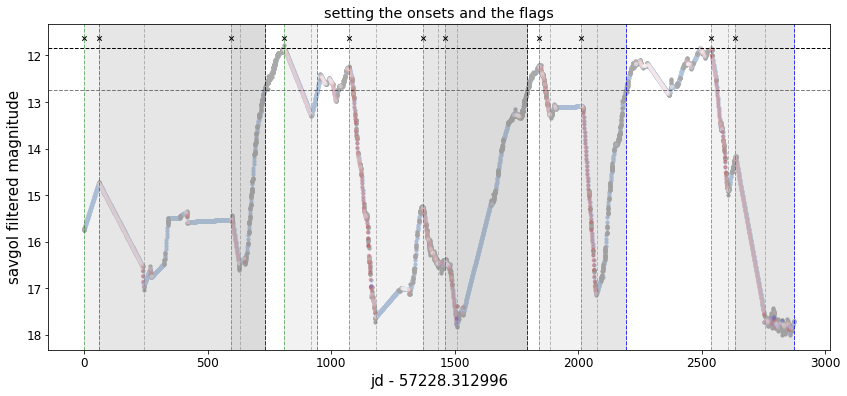

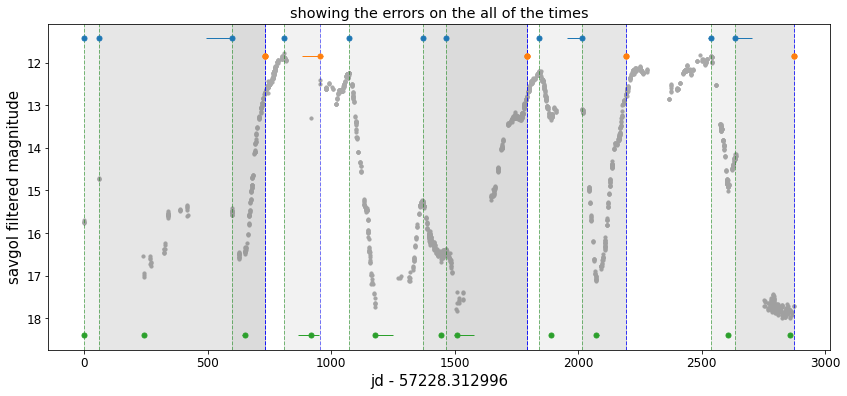

median max light: 12.333
mean max light: 12.334
min decline depth: 0.9
length of light curve: 2873.7425900000017
sampling percent of light curve: 17.12
{'median_max': 12.333, 'mean_max': 12.334, 'min_depth': 0.9, 'baseline': 2873.7425900000017, 'sampling': 17.12}


onset_time  onset_err_l  onset_err_r  onset_flag      end_time  \
0   57228.312996          NaN   120.592337         1.0  57960.349266   
1   57288.263288          NaN   105.609873         0.0  57960.349266   
2   57826.534563   105.103018     0.509168         0.0  57960.349266   
3   58039.200608     4.991403     2.005709         0.0  58182.663329   
4   58302.446623     2.009783     6.977992         0.0  59020.429382   
5   58599.549978     4.044808     2.490097         0.0  59020.429382   
6   58691.349491     1.480408     4.027305         0.0  59020.429382   
7   59071.291966     1.947497     4.497799         0.0  59421.425271   
8   59244.635723    61.204140     2.010682         0.0  59421.425271   
9   59766.356327    12.983670     0.980959         0.0  60102.055586   
10  59863.018790     1.621183    67.540238         0.0  60102.055586   

    end_err_l  end_err_r  end_flag    depth_time  depth_err_l  depth_err_r  \
0    5.975694   2.993444       0.0  57228.312996          NaN   120.592337   
1    5.975694   2.993444       0.0  57469.477275          NaN    41.461276   
2    5.975694   2.993444       0.0  57879.616224    12.031538     5.952951   
3   71.723722  12.897007       0.0  58148.665802    54.727039    29.407164   
4    2.494184   3.948855       0.0  58406.243000     6.994343    70.707118   
5    2.494184   3.948855       0.0  58674.248847     3.439632     3.076962   
6    2.494184   3.948855       0.0  58738.295235    12.974535    69.156112   
7    4.005409   2.455531       0.0  59117.247348     6.493146     1.504064   
8    4.005409   2.455531       0.0  59300.517828     2.509064    12.977048   
9    9.885475        NaN       1.0  59834.008363     1.569077     0.371104   
10   9.885475        NaN       1.0  60084.177675     5.059602          NaN   

    decline_depth  min_mag  sampling  
0        3.014076   15.750      3.33  
1        2.242000   16.974      2.59  
2        0.958000   16.482     24.44  
3        1.434000   13.300      3.45  
4        5.336000   17.631     19.46  
5        1.375000   16.665     39.78  
6        1.409000   17.828     19.39  
7        1.033000   13.297     14.86  
8        4.042000   17.133     28.65  
9        3.032000   14.885     35.05  
10       3.742000   18.001     19.17

In [278]:
decline_detection(oband,use_iter_smooth=False,debug_mode=False)#,
#                   outfile='/Users/ccra8514/Desktop/test_out.h5')#,decline_min_depth=0.8013270936716312)

In [ ]:
decline_detection(oband,use_iter_smooth=False,debug_mode=True)#,
#                  plotfile='/Users/ccra8514/Desktop/ASAS-RCB-21')

In [645]:
# decline_detection(oband,use_iter_smooth=True,debug_mode=True)#,
# #                  plotfile='/Users/ccra8514/Desktop/ASAS-RCB-21')

In [ ]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],oband['ujy'],s=10)#/(80000),s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('o-band flux (ujy)')
# # plt.ylim(-100,1000)
# # plt.ylim(0.6,1.2)
# # plt.xlim(1000,2000)
# plt.show()

# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10)#/(80000),s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('o-band mag')
# # plt.ylim(top=1.2)
# # plt.ylim(0.6,1.2)
# # plt.xlim(1000,2000)
# plt.show()

In [243]:
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_WISEJ194218.38-203247.5_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_AOHer_ATLAS.csv')
atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-14_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-16_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-19_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-21_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-7_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_EROS2-CG-RCB-10_ATLAS.csv')
atlas

mjd       m     dm     ujy  dujy  f  err  reduced_chi  \
0     57228.312996  15.750  0.023  1820.0  42.0  o    0         1.77   
1     57228.336591  15.729  0.022  1856.0  40.0  o    0         1.52   
2     57228.340302  15.703  0.021  1900.0  40.0  o    0         1.74   
3     57228.362466  15.758  0.026  1806.0  46.0  o    0         1.00   
4     57228.366169  15.737  0.022  1842.0  40.0  o    0         1.58   
...            ...     ...    ...     ...   ... ..  ...          ...   
2940  60102.016247  17.698  0.097   302.0  29.0  o    0         1.08   
2941  60102.055586  17.709  0.107   300.0  32.0  o    0         1.50   
2942  60109.173979  18.482  0.085   147.0  12.0  c    0         3.07   
2943  60109.177839  18.499  0.081   145.0  12.0  c    0         3.04   
2944  60109.183983  18.367  0.078   163.0  13.0  c    0         3.40   

             ra       dec        x         y   maj   min   phi  apfit  \
0     251.87391 -15.42304  7376.48   8986.20  3.50  3.44 -76.1 -0.475   
1     251.87391 -15.42304  5894.92  10454.92  3.50  3.23  -4.0 -0.472   
2     251.87391 -15.42304  9112.80    733.87  3.67  3.31  89.9 -0.477   
3     251.87391 -15.42304  5898.51  10460.16  3.45  3.16  -8.5 -0.478   
4     251.87391 -15.42304  9114.39    738.79  3.64  3.23 -81.0 -0.471   
...         ...       ...      ...       ...   ...   ...   ...    ...   
2940  251.87391 -15.42304  8482.84   8720.26  2.99  2.37 -18.1 -0.393   
2941  251.87391 -15.42304  8429.85   8798.32  3.58  2.80  -5.8 -0.429   
2942  251.87391 -15.42304  3660.82   2261.67  2.46  2.22  47.8 -0.384   
2943  251.87391 -15.42304  3682.33   2296.87  2.29  2.09  47.8 -0.390   
2944  251.87391 -15.42304  3627.19   2212.86  2.40  2.19  52.5 -0.383   

      mag5sig    sky             obs  
0       18.61  19.73  02a57228o0091o  
1       18.60  19.72  02a57228o0116o  
2       18.66  19.79  02a57228o0120o  
3       18.62  19.72  02a57228o0144o  
4       18.68  19.82  02a57228o0148o  
...       ...    ...             ...  
2940    18.61  19.18  03a60102o0701o  
2941    18.31  18.99  03a60102o0747o  
2942    19.34  21.39  04a60109o0493c  
2943    19.40  21.37  04a60109o0500c  
2944    19.33  21.33  04a60109o0513c  

[2945 rows x 19 columns]

In [244]:
oband = atlas[atlas['f']=='o']
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
oband.rename(columns={'mjd': 'jd', 'm': 'mag'},inplace=True)
oband

jd     mag     dm     ujy  dujy  f  err  reduced_chi  \
0     57228.312996  15.750  0.023  1820.0  42.0  o    0         1.77   
1     57228.336591  15.729  0.022  1856.0  40.0  o    0         1.52   
2     57228.340302  15.703  0.021  1900.0  40.0  o    0         1.74   
3     57228.362466  15.758  0.026  1806.0  46.0  o    0         1.00   
4     57228.366169  15.737  0.022  1842.0  40.0  o    0         1.58   
...            ...     ...    ...     ...   ... ..  ...          ...   
2161  60091.925509  18.020  0.075   225.0  17.0  o    0         4.50   
2162  60091.933577  17.917  0.054   247.0  13.0  o    0         9.08   
2163  60091.935140  17.860  0.054   261.0  14.0  o    0         6.59   
2164  60102.016247  17.698  0.097   302.0  29.0  o    0         1.08   
2165  60102.055586  17.709  0.107   300.0  32.0  o    0         1.50   

             ra       dec        x         y   maj   min   phi  apfit  \
0     251.87391 -15.42304  7376.48   8986.20  3.50  3.44 -76.1 -0.475   
1     251.87391 -15.42304  5894.92  10454.92  3.50  3.23  -4.0 -0.472   
2     251.87391 -15.42304  9112.80    733.87  3.67  3.31  89.9 -0.477   
3     251.87391 -15.42304  5898.51  10460.16  3.45  3.16  -8.5 -0.478   
4     251.87391 -15.42304  9114.39    738.79  3.64  3.23 -81.0 -0.471   
...         ...       ...      ...       ...   ...   ...   ...    ...   
2161  251.87391 -15.42304  4170.15   5653.47  2.21  2.05 -30.2 -0.403   
2162  251.87391 -15.42304  4227.79   5730.06  2.37  2.12 -22.6 -0.403   
2163  251.87391 -15.42304  4249.28   5614.83  2.33  2.08 -28.8 -0.399   
2164  251.87391 -15.42304  8482.84   8720.26  2.99  2.37 -18.1 -0.393   
2165  251.87391 -15.42304  8429.85   8798.32  3.58  2.80  -5.8 -0.429   

      mag5sig    sky             obs  
0       18.61  19.73  02a57228o0091o  
1       18.60  19.72  02a57228o0116o  
2       18.66  19.79  02a57228o0120o  
3       18.62  19.72  02a57228o0144o  
4       18.68  19.82  02a57228o0148o  
...       ...    ...             ...  
2161    19.29  20.31  03a60092o0495o  
2162    19.26  20.41  03a60092o0512o  
2163    19.30  20.40  03a60092o0515o  
2164    18.61  19.18  03a60102o0701o  
2165    18.31  18.99  03a60102o0747o  

[2166 rows x 19 columns]

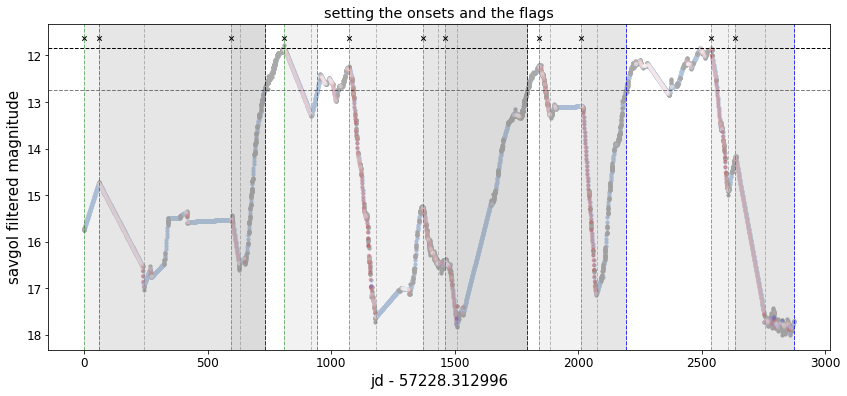

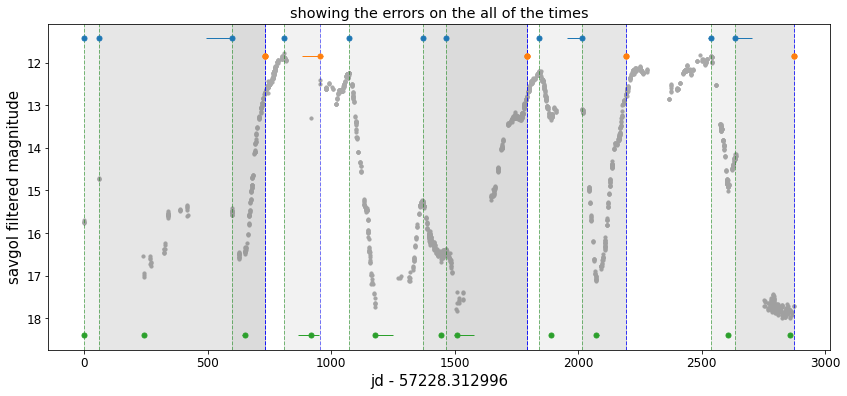

median max light: 12.333
mean max light: 12.334
min decline depth: 0.9
length of light curve: 2873.7425900000017
sampling percent of light curve: 17.12
{'median_max': 12.333, 'mean_max': 12.334, 'min_depth': 0.9, 'baseline': 2873.7425900000017, 'sampling': 17.12}


onset_time  onset_err_l  onset_err_r  onset_flag      end_time  \
0   57228.312996          NaN   120.592337         1.0  57960.349266   
1   57288.263288          NaN   105.609873         0.0  57960.349266   
2   57826.534563   105.103018     0.509168         0.0  57960.349266   
3   58039.200608     4.991403     2.005709         0.0  58182.663329   
4   58302.446623     2.009783     6.977992         0.0  59020.429382   
5   58599.549978     4.044808     2.490097         0.0  59020.429382   
6   58691.349491     1.480408     4.027305         0.0  59020.429382   
7   59071.291966     1.947497     4.497799         0.0  59421.425271   
8   59244.635723    61.204140     2.010682         0.0  59421.425271   
9   59766.356327    12.983670     0.980959         0.0  60102.055586   
10  59863.018790     1.621183    67.540238         0.0  60102.055586   

    end_err_l  end_err_r  end_flag    depth_time  depth_err_l  depth_err_r  \
0    5.975694   2.993444       0.0  57228.312996          NaN   120.592337   
1    5.975694   2.993444       0.0  57469.477275          NaN    41.461276   
2    5.975694   2.993444       0.0  57879.616224    12.031538     5.952951   
3   71.723722  12.897007       0.0  58148.665802    54.727039    29.407164   
4    2.494184   3.948855       0.0  58406.243000     6.994343    70.707118   
5    2.494184   3.948855       0.0  58674.248847     3.439632     3.076962   
6    2.494184   3.948855       0.0  58738.295235    12.974535    69.156112   
7    4.005409   2.455531       0.0  59117.247348     6.493146     1.504064   
8    4.005409   2.455531       0.0  59300.517828     2.509064    12.977048   
9    9.885475        NaN       1.0  59834.008363     1.569077     0.371104   
10   9.885475        NaN       1.0  60084.177675     5.059602          NaN   

    decline_depth  min_mag  sampling  
0        3.014076   15.750      3.33  
1        2.242000   16.974      2.59  
2        0.958000   16.482     24.44  
3        1.434000   13.300      3.45  
4        5.336000   17.631     19.46  
5        1.375000   16.665     39.78  
6        1.409000   17.828     19.39  
7        1.033000   13.297     14.86  
8        4.042000   17.133     28.65  
9        3.032000   14.885     35.05  
10       3.742000   18.001     19.17

In [298]:
decline_detection(oband,use_iter_smooth=False,debug_mode=False)#,decline_min_depth=0.5,
#                  plotfile='/Users/courtneycrawford/Desktop/ASAS-RCB-16')#'/Users/ccra8514/Desktop/WISEJ194'

# Testing reading in from the output HDF5 file - it works

In [279]:
# Load file and meta
with pd.HDFStore('/Users/ccra8514/Desktop/test_out.h5') as hdf_store:
    metadata = hdf_store.get_storer('data').attrs.metadata
    output_frame = hdf_store.get('data')
    # If you want to set up meta in the df again
    output_frame.attrs.update(metadata)

In [283]:
output_frame

onset_time  onset_err_l  onset_err_r  onset_flag      end_time  \
0   57228.312996          NaN   120.592337         1.0  57960.349266   
1   57288.263288          NaN   105.609873         0.0  57960.349266   
2   57826.534563   105.103018     0.509168         0.0  57960.349266   
3   58039.200608     4.991403     2.005709         0.0  58182.663329   
4   58302.446623     2.009783     6.977992         0.0  59020.429382   
5   58599.549978     4.044808     2.490097         0.0  59020.429382   
6   58691.349491     1.480408     4.027305         0.0  59020.429382   
7   59071.291966     1.947497     4.497799         0.0  59421.425271   
8   59244.635723    61.204140     2.010682         0.0  59421.425271   
9   59766.356327    12.983670     0.980959         0.0  60102.055586   
10  59863.018790     1.621183    67.540238         0.0  60102.055586   

    end_err_l  end_err_r  end_flag    depth_time  depth_err_l  depth_err_r  \
0    5.975694   2.993444       0.0  57228.312996          NaN   120.592337   
1    5.975694   2.993444       0.0  57469.477275          NaN    41.461276   
2    5.975694   2.993444       0.0  57879.616224    12.031538     5.952951   
3   71.723722  12.897007       0.0  58148.665802    54.727039    29.407164   
4    2.494184   3.948855       0.0  58406.243000     6.994343    70.707118   
5    2.494184   3.948855       0.0  58674.248847     3.439632     3.076962   
6    2.494184   3.948855       0.0  58738.295235    12.974535    69.156112   
7    4.005409   2.455531       0.0  59117.247348     6.493146     1.504064   
8    4.005409   2.455531       0.0  59300.517828     2.509064    12.977048   
9    9.885475        NaN       1.0  59834.008363     1.569077     0.371104   
10   9.885475        NaN       1.0  60084.177675     5.059602          NaN   

    decline_depth  min_mag  sampling  
0        3.014076   15.750      3.33  
1        2.242000   16.974      2.59  
2        0.958000   16.482     24.44  
3        1.434000   13.300      3.45  
4        5.336000   17.631     19.46  
5        1.375000   16.665     39.78  
6        1.409000   17.828     19.39  
7        1.033000   13.297     14.86  
8        4.042000   17.133     28.65  
9        3.032000   14.885     35.05  
10       3.742000   18.001     19.17

In [284]:
output_frame.attrs

{'median_max': 12.333,
 'mean_max': 12.334,
 'min_depth': 0.9,
 'baseline': 2873.7425900000017,
 'sampling': 17.12}

In [ ]:
### testing out some data analysis stuff

In [308]:
total_days_obs = np.floor(np.ceil(output_frame.attrs['baseline'])*(0.01*output_frame.attrs['sampling']))
baseline = output_frame.attrs['baseline']
baseline

2873.7425900000017

In [311]:
## frequency of declines (per year)
365*len(output_frame)/baseline

1.3971327891270866

In [307]:
total_decline_time = 0
for i in range(0,len(output_frame)):
#     print(output_frame.iloc[i])
    if i == 0 or output_frame.iloc[i].end_time != output_frame.iloc[i-1].end_time:
        decline = output_frame.iloc[i]
        individual_decline_time = decline.end_time-decline.onset_time
        total_decline_time = total_decline_time + individual_decline_time
        
print(total_decline_time)

2279.314314000003


In [309]:
## percent of time in decline
100*total_decline_time/baseline 

79.31518716852095

# Benchmarking with a Mira variable

In [162]:
# mira = pd.read_csv('/Users/ccra8514/Desktop/query_1699926198.65723l/I/OGLE-BLG-LPV-060312.dat',
#                    names=['jd','mag','magerr'],sep='\s+')
mira = pd.read_csv('/Users/ccra8514/Desktop/query_1699926198.65723l/I/OGLE-BLG-LPV-096697.dat',
                   names=['jd','mag','magerr'],sep='\s+')
mira

jd     mag  magerr
0     5260.85336  13.466   0.005
1     5260.90029  13.474   0.005
2     5261.79151  13.496   0.005
3     5262.82995  13.540   0.005
4     5264.81438  13.611   0.005
...          ...     ...     ...
8364  8784.51026  16.144   0.008
8365  8784.52408  16.117   0.008
8366  8785.50189  16.094   0.010
8367  8786.50070  16.099   0.010
8368  8787.50719  16.127   0.008

[8369 rows x 3 columns]

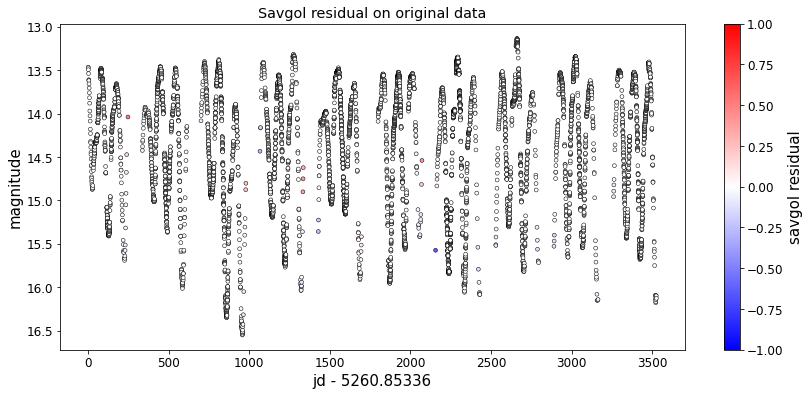

Std dev: 0.017033585893987957
95 percentile: 0.01251805090053466
99 percentile: 0.02108642621443443


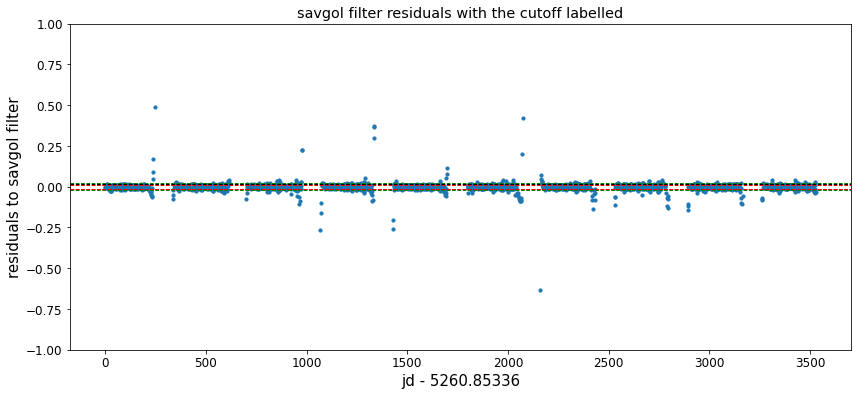

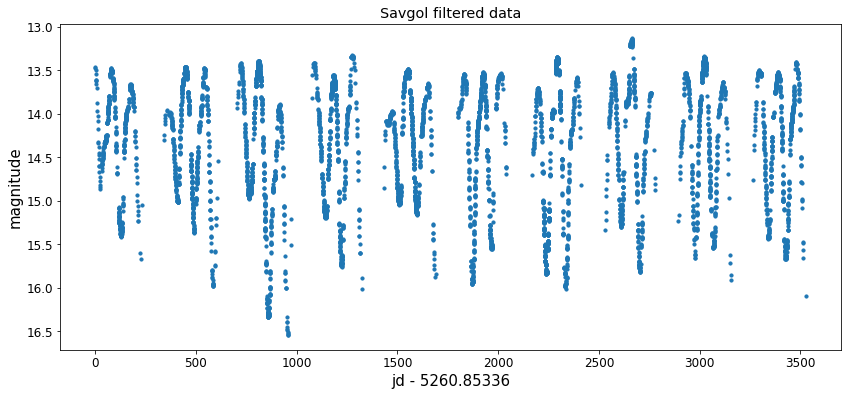

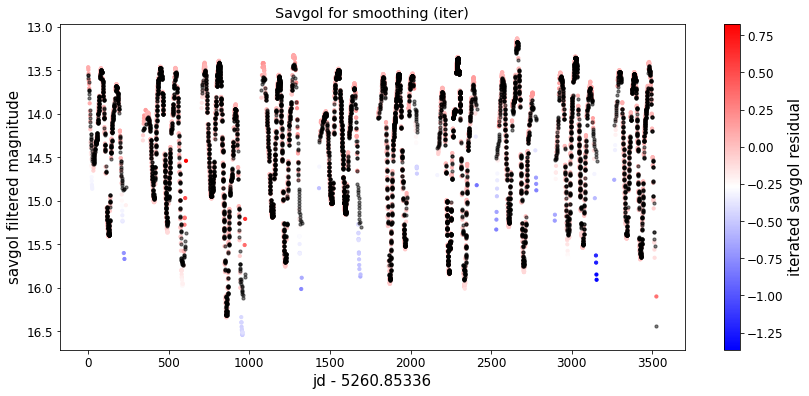

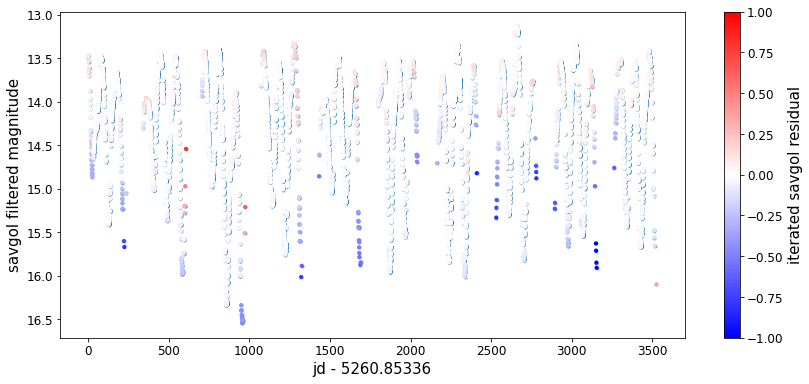

data resolution: 0.4684000717417298


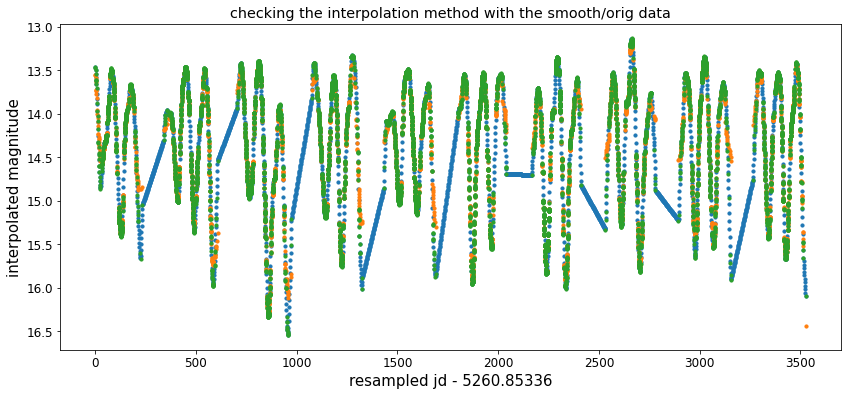

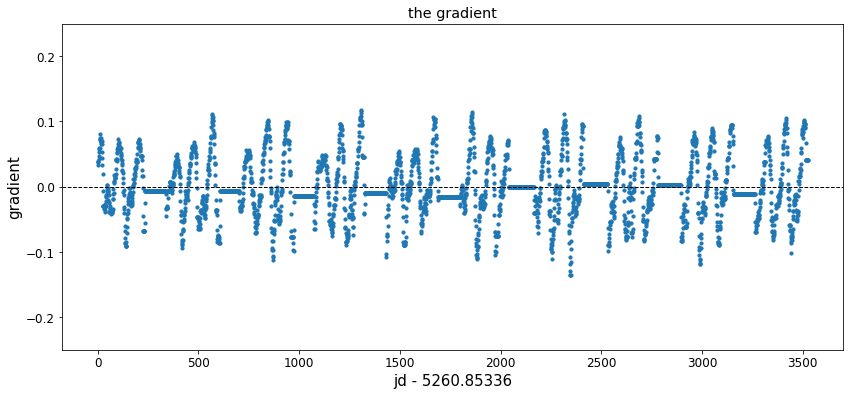

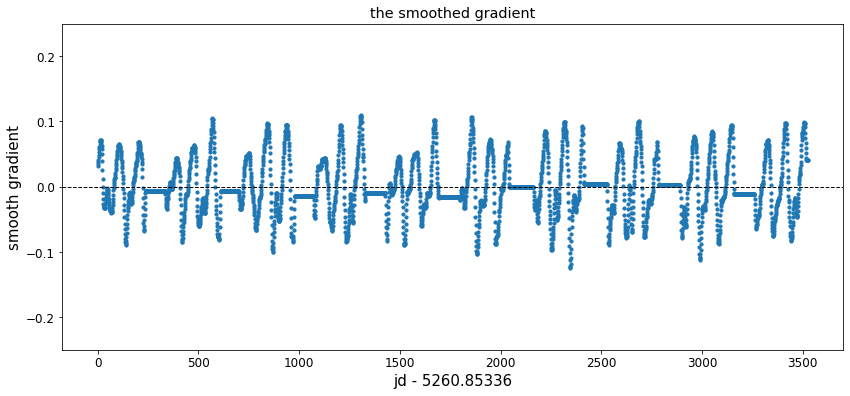

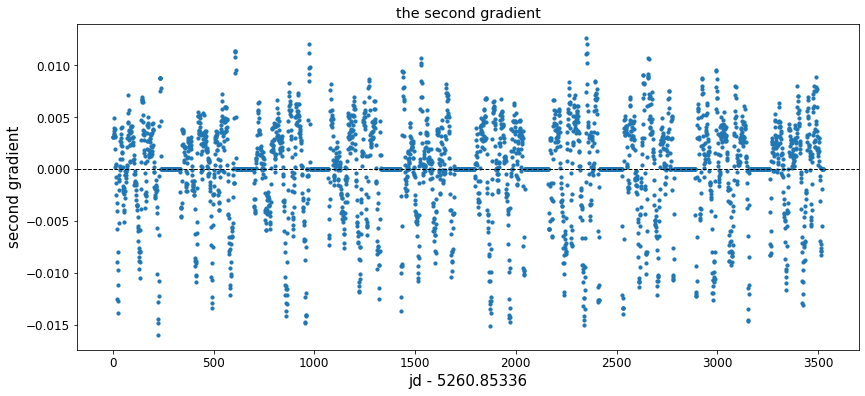

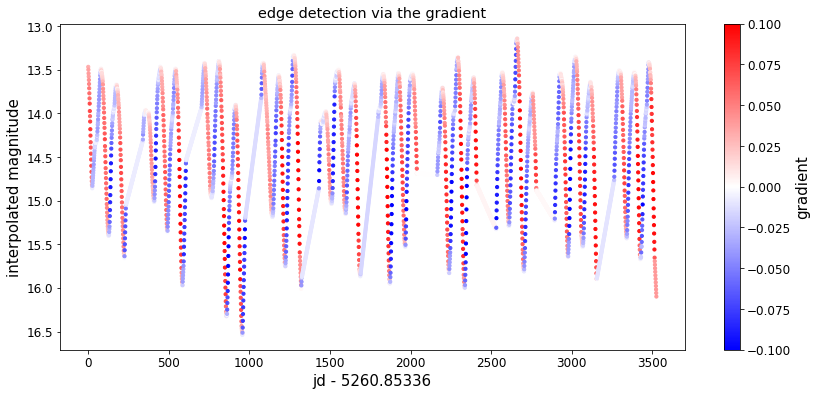

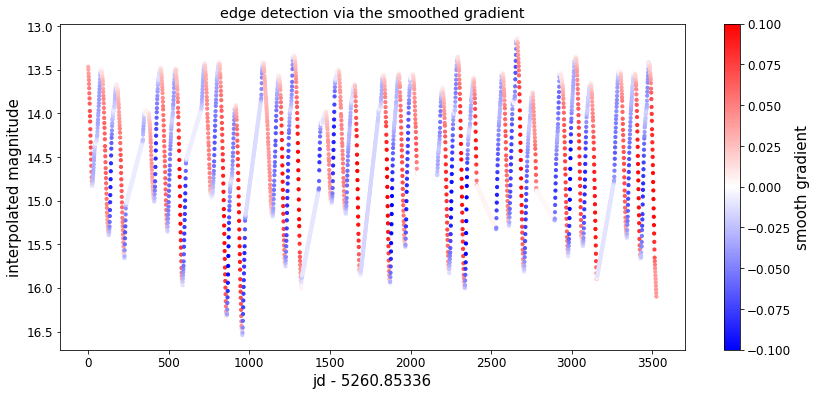

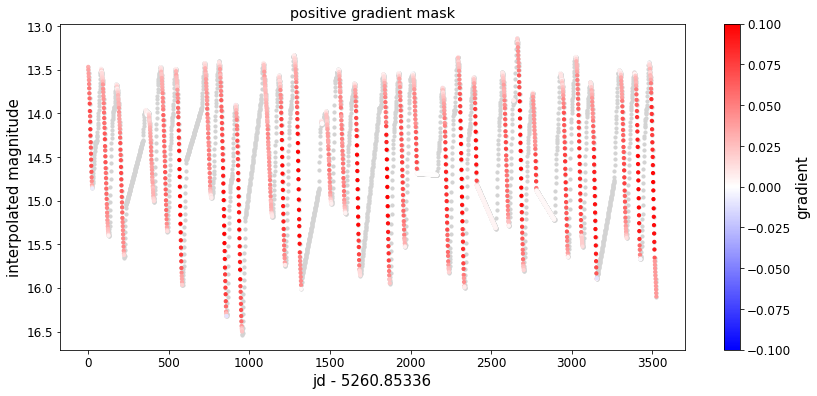

actually detecting the declines
0
13.466
1.3634537284837354
80
13.487228451198456
1.9144315119594921
175
13.672980048732878
1.9686425254107522
372
13.988448841238224
1.0246916878856354
449
13.469908083469925
1.8920570137137975
542
13.48937169922625
2.4814630829244884
722
13.42307613910083
1.5473560186351065
812
13.411787799635938
2.8917688672364363
914
13.90182185836035
2.6268614809697866
1086
13.422007090588275
1.7668860586878754
1183
13.565961041982076
2.187674316230895
1275
13.333814135920026
2.6381442732095
1474
13.975437821311889
1.0596930017306665
1551
13.507233088551931
1.6463759227014751
1652
13.658527839438221
2.208733264250535
1830
13.549340435686265
2.4008031570423487
1925
13.536504393951839
1.9953057786048856
2012
13.539630173923427
1.1649629495427156
2197
13.703044506140525
2.118879820596785
2292
13.358619936436474
2.6448958000631055
2391
13.588072818614439
1.730061202411905
2569
13.532795174493364
1.7576383950818641
2660
13.14054514601439
2.6637962464995404
2756
13.763592

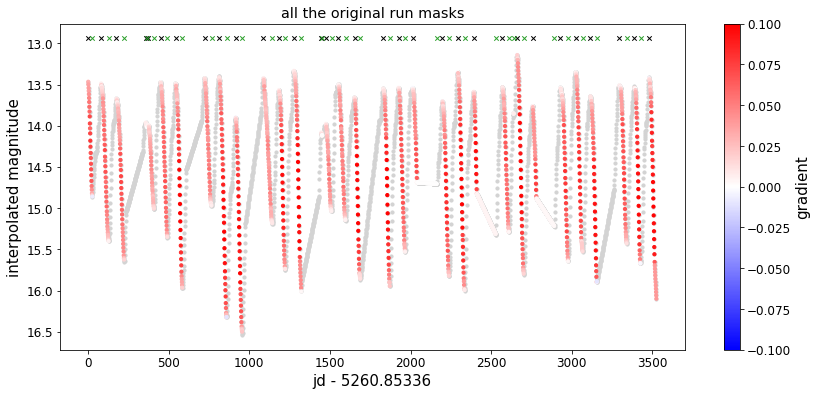

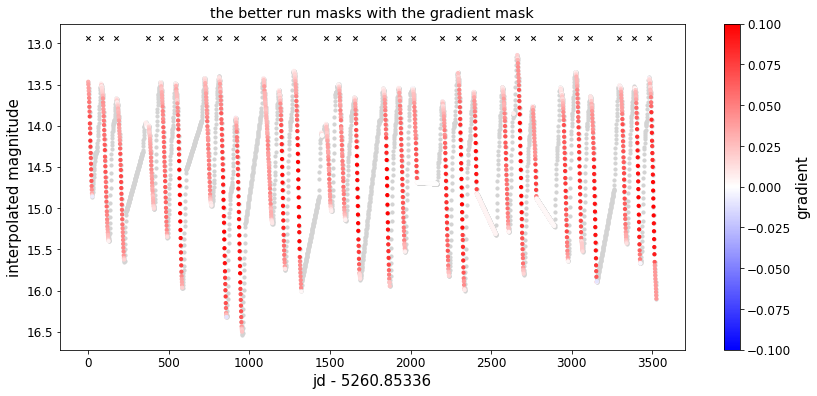

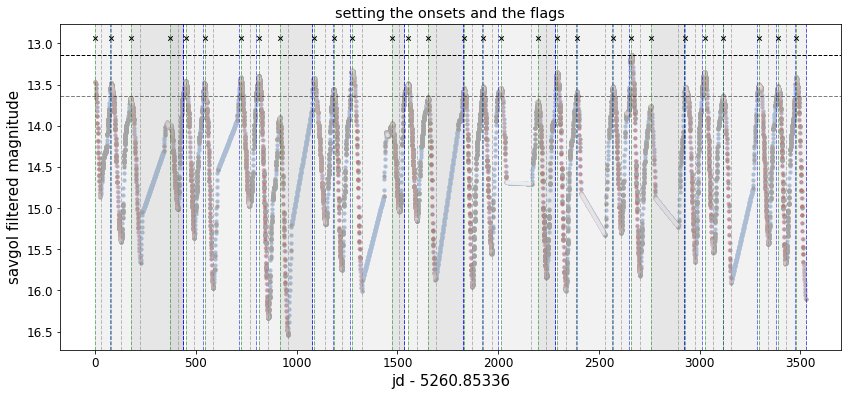

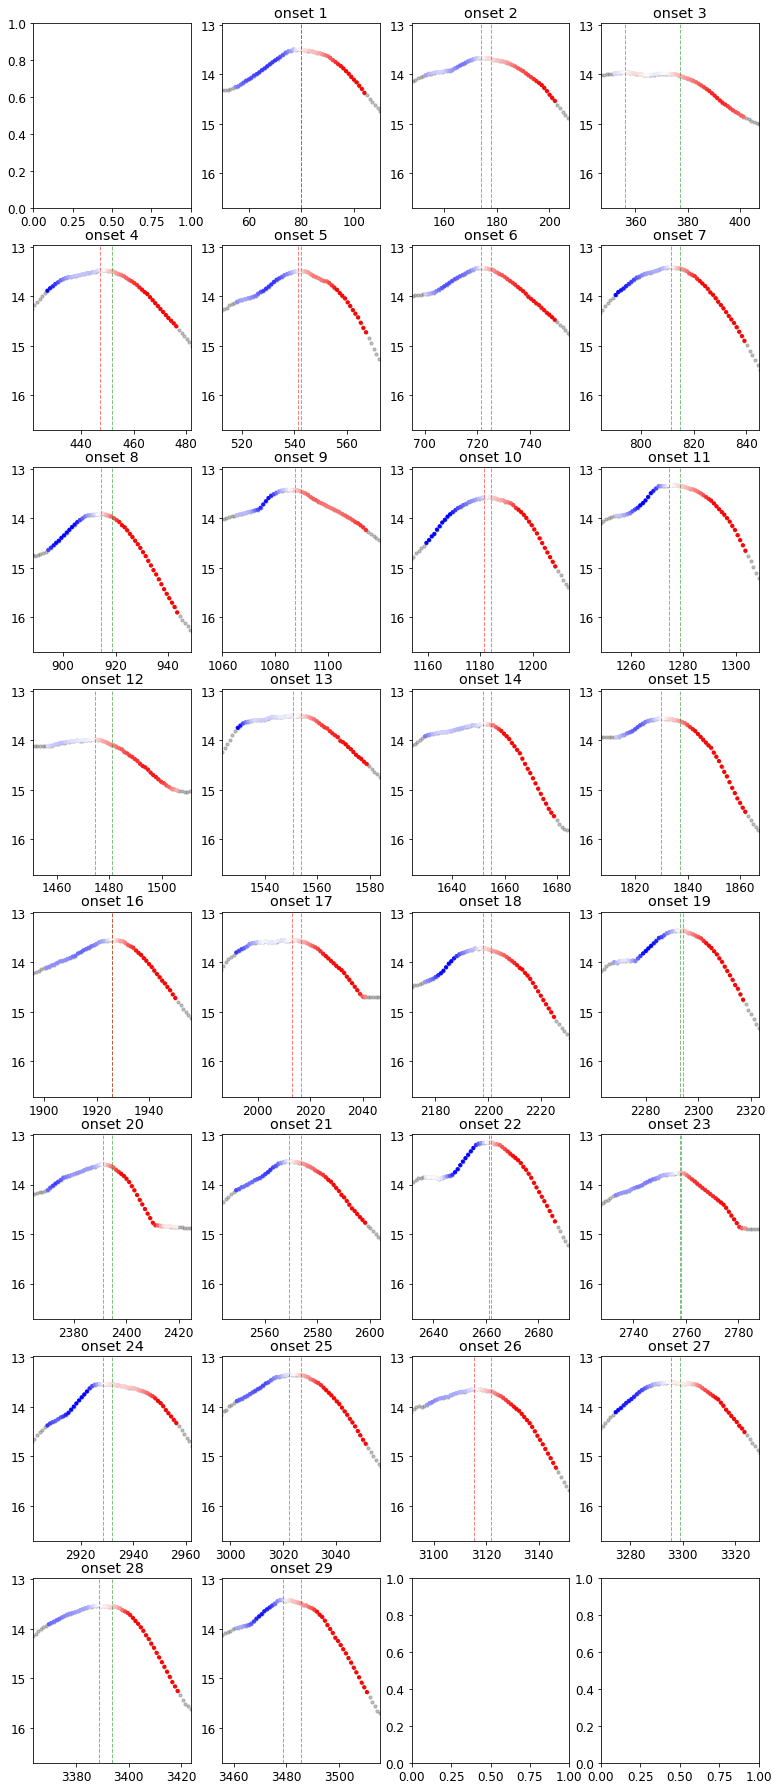

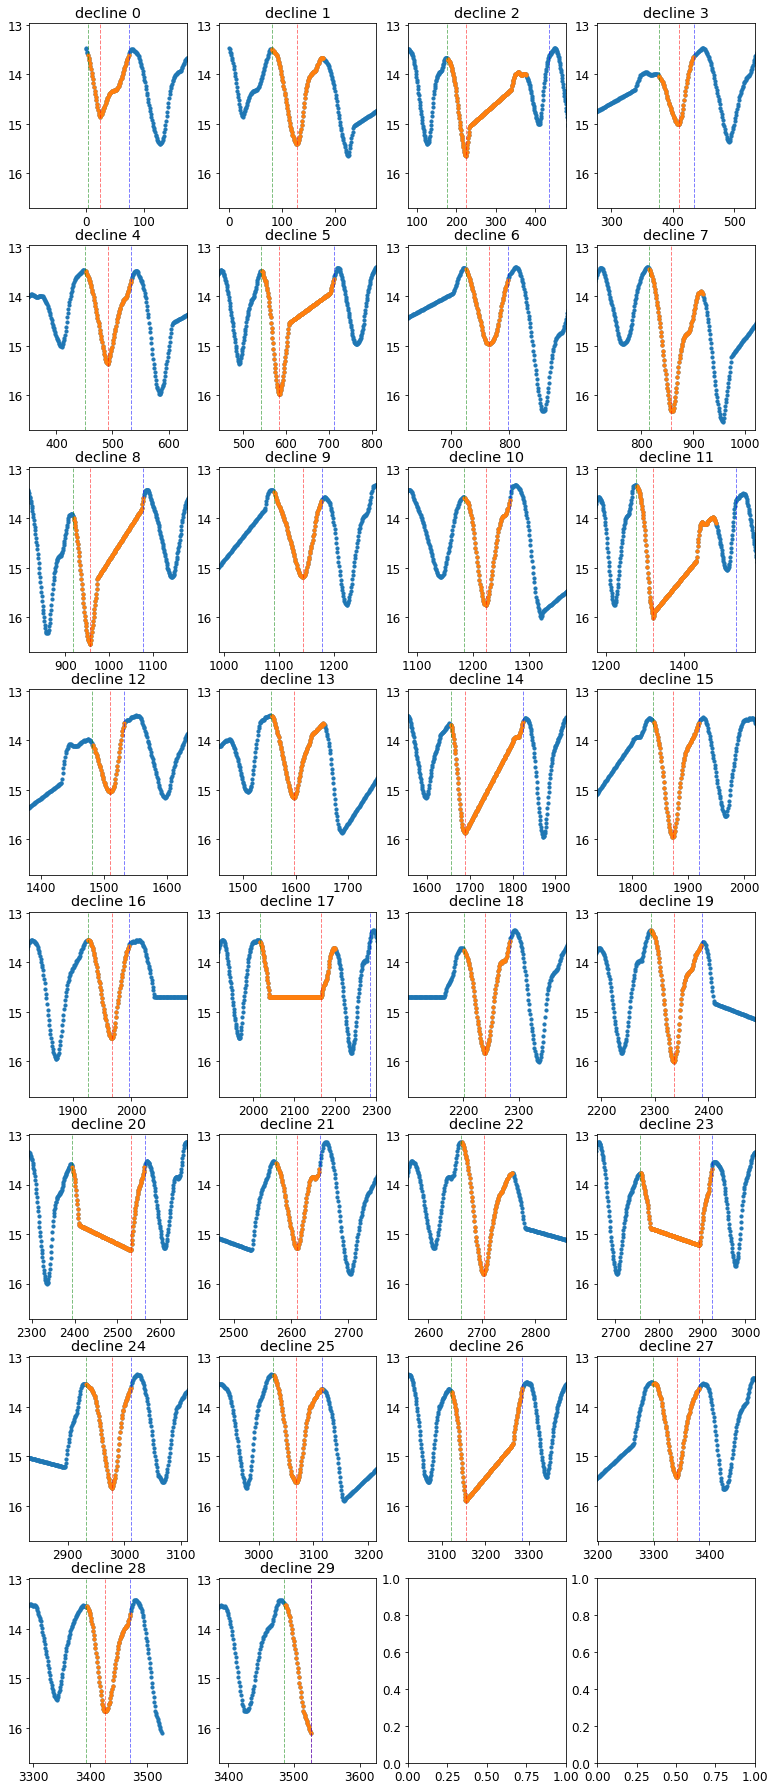

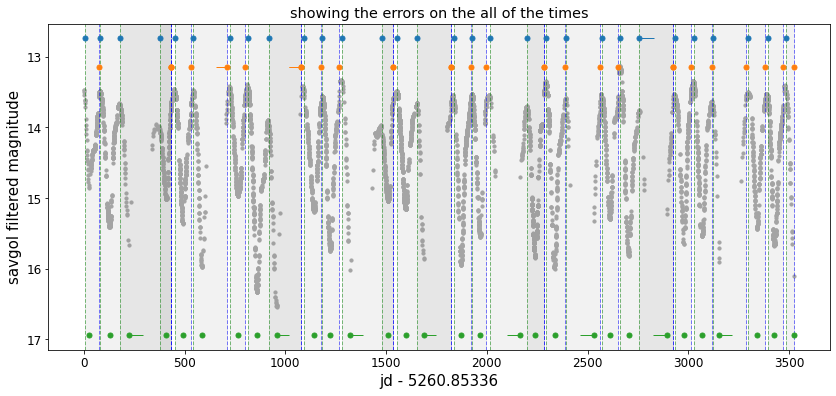

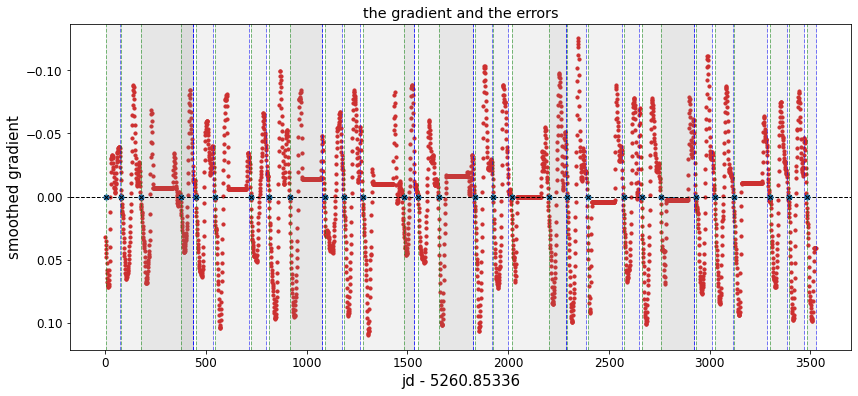

    onset_time  onset_err_l  onset_err_r  onset_flag    end_time  end_err_l  \
0   5264.81438          NaN     5.483810         1.0  5334.76488   3.450840   
1   5340.87518     1.019690     0.916920         0.0  5694.88860   0.590665   
2   5438.49893     1.916585     2.554500         0.0  5694.88860   0.590665   
3   5637.81281     9.961500     2.046440         0.0  5694.88860   0.590665   
4   5712.64641     1.958965     0.966675         0.0  5794.67664   0.600295   
5   5803.50972     3.449430     1.066235         0.0  5972.87575  56.691110   
6   5985.81385     3.974670     1.545900         0.0  6058.90187   0.546620   
7   6075.62076     2.408630     0.607330         0.0  6338.84197  62.166225   
8   6179.52504     3.483610     1.520640         0.0  6338.84197  62.166225   
9   6350.84491     7.986425     4.986290         0.0  6437.91925   0.569345   
10  6444.77593     1.031725     0.552185         0.0  6526.63343   1.520805   
11  6539.48018     3.472525     6.003000         0.0

onset_time  onset_err_l  onset_err_r  onset_flag    end_time  end_err_l  \
0   5264.81438          NaN     5.483810         1.0  5334.76488   3.450840   
1   5340.87518     1.019690     0.916920         0.0  5694.88860   0.590665   
2   5438.49893     1.916585     2.554500         0.0  5694.88860   0.590665   
3   5637.81281     9.961500     2.046440         0.0  5694.88860   0.590665   
4   5712.64641     1.958965     0.966675         0.0  5794.67664   0.600295   
5   5803.50972     3.449430     1.066235         0.0  5972.87575  56.691110   
6   5985.81385     3.974670     1.545900         0.0  6058.90187   0.546620   
7   6075.62076     2.408630     0.607330         0.0  6338.84197  62.166225   
8   6179.52504     3.483610     1.520640         0.0  6338.84197  62.166225   
9   6350.84491     7.986425     4.986290         0.0  6437.91925   0.569345   
10  6444.77593     1.031725     0.552185         0.0  6526.63343   1.520805   
11  6539.48018     3.472525     6.003000         0.0  6792.91837   0.544090   
12  6741.91535     3.059695     1.977735         0.0  6792.91837   0.544090   
13  6814.75243     1.431895     0.561140         0.0  7084.81902   3.476380   
14  6915.51998     2.996770     3.516870         0.0  7084.81902   3.476380   
15  7097.79549     3.490745     1.032680         0.0  7180.75032   0.528695   
16  7186.69890     0.948635     0.607205         0.0  7257.69709   1.102780   
17  7277.49883     2.961160     7.538410         0.0  7545.58854   4.405130   
18  7461.79519     2.501785     2.049740         0.0  7545.58854   4.405130   
19  7553.85406     1.508260     0.478515         0.0  7648.58717   5.025750   
20  7655.48129     2.949110     5.002420         0.0  7824.87871   2.496960   
21  7834.78845     4.002180     2.006055         0.0  7910.92758   0.539755   
22  7922.61741     2.883775     0.636305         0.0  8183.88494   4.032060   
23  8018.50224     2.488425    71.673315         0.0  8183.88494   4.032060   
24  8192.78559     3.953290     1.552255         0.0  8272.64530   3.416180   
25  8287.81438     1.454580     0.868295         0.0  8376.51386   2.955245   
26  8382.48308     5.492830     1.518260         0.0  8546.84753   6.492465   
27  8559.77378     1.940625     1.543165         0.0  8642.56196   1.000305   
28  8654.52240     3.326985     1.508530         0.0  8731.62230   1.007540   
29  8746.53486     3.027995     0.979885         0.0  8786.50070   9.983725   

    end_err_r  end_flag  depth_time  depth_err_l  depth_err_r  decline_depth  \
0    0.588190       0.0  5285.76013     3.988530     5.045375       1.221455   
1    0.976100       0.0  5387.80776     0.581900     0.957995       1.918000   
2    0.976100       0.0  5485.49798    10.006935    69.669855       1.992000   
3    0.976100       0.0  5669.91810     1.046790     2.975865       0.994000   
4    3.454175       0.0  5752.54609     1.969885     4.056960       1.873000   
5    5.012125       0.0  5845.57865     2.992585     6.976150       2.479000   
6    1.410720       0.0  6025.88224     0.991155     3.516700       1.527000   
7    6.025870       0.0  6118.50595     0.895790     0.616445       2.899000   
8    6.025870       0.0  6217.54594     6.029305    63.647935       2.574000   
9    2.396615       0.0  6403.68468     0.964080     0.592950       1.730000   
10   3.457940       0.0  6483.58443     1.484260     1.471230       2.188000   
11   2.399905       0.0  6582.49944     6.496090    61.680710       2.662000   
12   2.399905       0.0  6769.70142     1.965660     0.593410       0.944000   
13   2.009945       0.0  6857.57209     0.896380     0.577740       1.647000   
14   2.009945       0.0  6949.52687     6.012505    60.158010       2.195000   
15   0.540675       0.0  7132.72591     1.397870     1.077330       2.340000   
16   2.967930       0.0  7227.78390     0.612405     0.990480       1.986000   
17   0.085145       0.0  7426.88843    66.700955     5.976395       1.137000   
18   0.085145       0.0  7500.9074

In [180]:
decline_detection(mira,use_iter_smooth=False,debug_mode=True,decline_min_depth=0.5)#,
#                  plotfile='/Users/ccra8514/Desktop/mira1')

# Benchmarking with a DY Per from OGLE

In [314]:
# dyper = pd.read_csv('/Users/ccra8514/Desktop/LMC-DYPer-3.txt',
#                    names=['jd','mag','magerr','seeing','skyerr'],sep='\s+')
dyper = pd.read_csv('/Users/ccra8514/Desktop/LMC-DYPer-9.txt',
                   names=['jd','mag','magerr','seeing','skyerr'],sep='\s+')
# dyper = pd.read_csv('/Users/ccra8514/Desktop/Wmen.txt',
#                    names=['jd','mag','magerr','seeing','skyerr'],sep='\s+')
dyper

jd     mag  magerr  seeing  skyerr
0    2.455262e+06  14.571   0.003    4.45   468.0
1    2.455262e+06  14.572   0.003    4.12   507.0
2    2.455263e+06  14.575   0.003    4.76   478.0
3    2.455263e+06  14.583   0.003    5.90   466.0
4    2.455265e+06  14.578   0.003    4.61   439.0
..            ...     ...     ...     ...     ...
852  2.459951e+06  14.525   0.003    6.37   713.0
853  2.459955e+06  14.553   0.003    5.66   497.0
854  2.459958e+06  14.564   0.003    4.73   373.0
855  2.459962e+06  14.589   0.003    4.76   285.0
856  2.459965e+06  14.610   0.003    5.43   550.0

[857 rows x 5 columns]

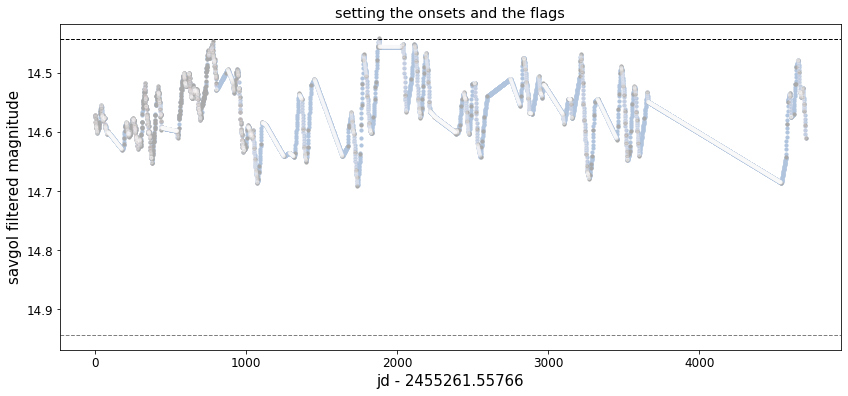

no declines


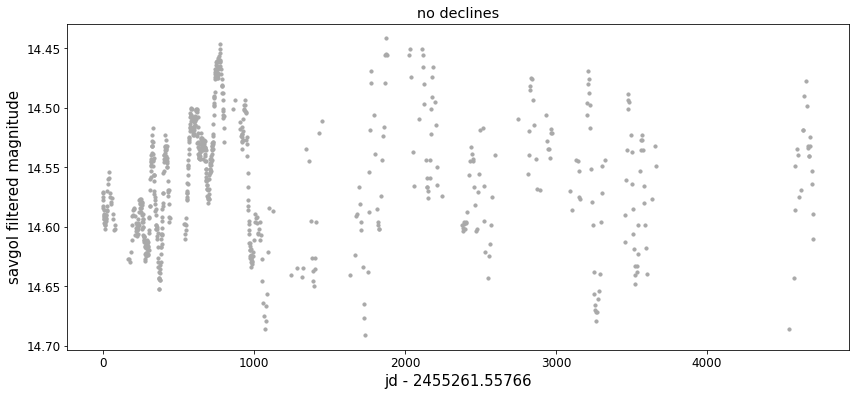

nan

In [315]:
decline_detection(dyper,use_iter_smooth=False,debug_mode=False,decline_min_depth=0.5)

In [316]:
from astropy.timeseries import LombScargle
def calc_lomb_scargle(t,y):
   oversample = 1
   tmax = t.max()
   tmin = t.min()
   df = 1.0 / (tmax - tmin)
   fmin = df
   fmax = 1 # maximum frequency in cycles per day (c/d)
 
   freq = np.arange(fmin, fmax, df / oversample)
   model = LombScargle(t, y)
   sc = model.power(freq, method="fast", normalization="psd")
 
   fct = np.sqrt(4./len(t))
   amp = np.sqrt(sc) * fct
   return freq, amp*1E6 # return frequency in muHz and amplitude in ppm

In [320]:
freq, amp = calc_lomb_scargle(dyper['jd'][dyper['jd']-dyper['jd'][0]<1000],
                              dyper['mag'][dyper['jd']-dyper['jd'][0]<1000])
# freq, amp = calc_lomb_scargle(dyper['jd'],
#                               dyper['mag'])

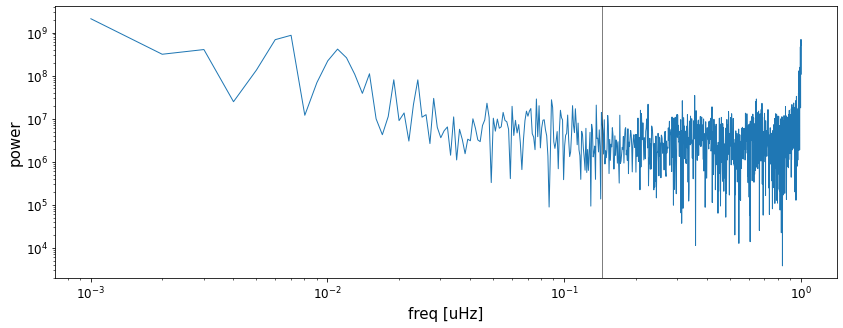

In [341]:
plt.figure(figsize=(14,5))
plt.plot(freq,amp**2)
plt.axvline(11.574/80,color='k',alpha=0.5)
# plt.axvline(3.4e-2,color='k')
plt.xlabel('freq [uHz]')
plt.ylabel('power')
plt.yscale('log')
plt.xscale('log')
plt.show()

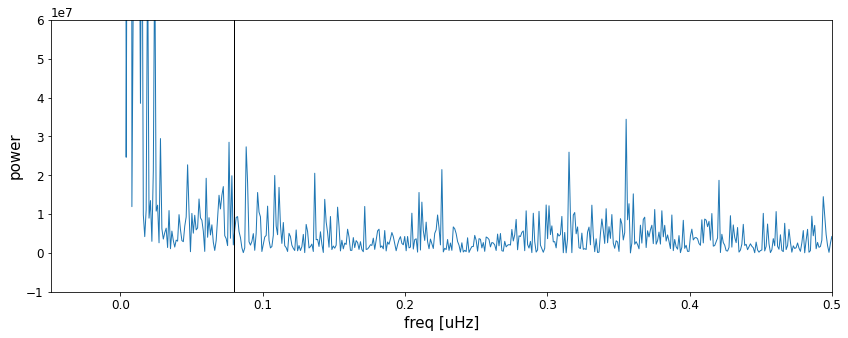

In [348]:
plt.figure(figsize=(14,5))
plt.plot(freq,amp**2)
# plt.axvline(11.574/84.5,color='k',alpha=0.5)
# plt.axvline(11.574/80.2,color='k',alpha=0.5)
plt.axvline(0.08,color='k')
plt.xlabel('freq [uHz]')
plt.ylabel('power')
# plt.xlim(10**-1,2e-1)
plt.ylim(-0.1e8,0.6e8)
plt.xlim(right=0.5)
plt.show()

In [326]:
peaks, prop = sp.signal.find_peaks(dyper['mag'],prominence=(0.05))

In [327]:
np.diff((dyper['jd']-dyper['jd'][0])[peaks])

array([101.79053,  91.92689,   1.96469, 170.26974, 149.87419, 377.90104,
        82.88262, 145.33691,  96.93982, 249.0977 ,  94.82778,  83.91895,
       187.29446,  65.84396,  73.92073,  85.8282 , 234.2928 ,  67.82817,
       263.19194,  82.82143, 224.17543,  51.93247, 105.85126, 172.34543,
        83.79207,  93.90784, 934.2597 ,  61.9682 ])

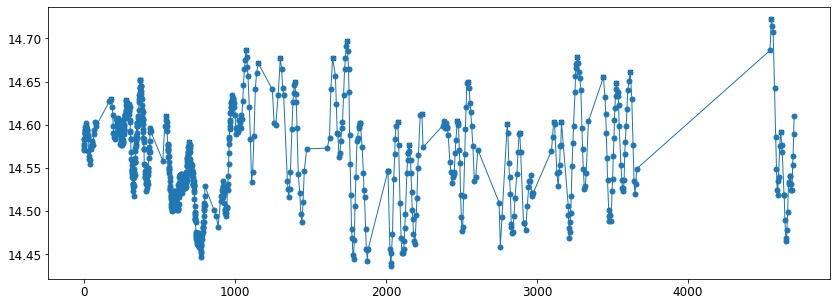

In [352]:
plt.figure(figsize=(14,5))
plt.plot((dyper['jd']-dyper['jd'][0]),dyper['mag'],marker='o')
plt.scatter((dyper['jd']-dyper['jd'][0])[peaks],dyper['mag'][peaks],marker='x',color='k')
# plt.xlim(0,1000)
plt.show()

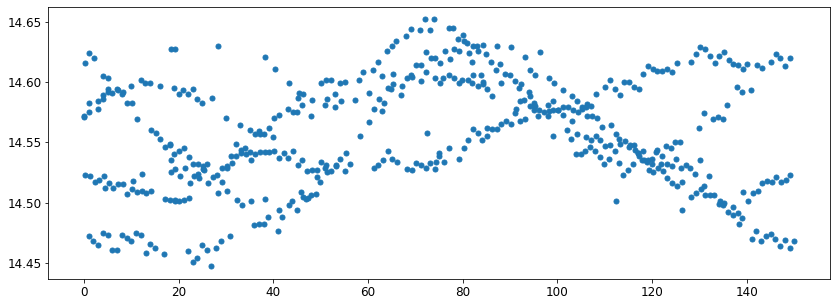

In [344]:
plt.figure(figsize=(14,5))
# plt.scatter((dyper['jd']-dyper['jd'][0])%150,dyper['mag'])
plt.scatter((dyper['jd'][dyper['jd']-dyper['jd'][0]<1000]-dyper['jd'][0])%150,
            dyper['mag'][dyper['jd']-dyper['jd'][0]<1000])
plt.show()

In [345]:
11.574/150

0.07715999999999999

In [333]:
from ipywidgets import interact, IntSlider, FloatSlider, fixed

In [334]:
def phase_wrapper(time,flux,phase):
    plt.figure(figsize=(14,5))
    plt.scatter((time)%phase,flux)
#     plt.show()

In [336]:
interact(phase_wrapper,
         time=fixed(dyper['jd']-dyper['jd'][0]),
         flux=fixed(dyper['mag']),
         phase=FloatSlider(min=60,max=100,step=0.5,value=80))

interactive(children=(FloatSlider(value=80.0, description='phase', min=60.0, step=0.5), Output()), _dom_classe…

<function __main__.phase_wrapper(time, flux, phase)>

In [338]:
11.574/80

0.144675

# Playing with the R CrB AAVSO data

In [353]:
AAVSO = pd.read_csv('../data/RCB_LC_FORTESTING/aavsodata_654aee1764b5f.txt')
# AAVSO

/var/folders/5_/9nz8zb3j1nd7ngnmb4btgpjh0000gq/T/ipykernel_29354/373677786.py:1: DtypeWarning: Columns (1,7,8,9,12,14,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  AAVSO = pd.read_csv('../data/RCB_LC_FORTESTING/aavsodata_654aee1764b5f.txt')


In [376]:
vband = AAVSO[AAVSO['Band']=='Vis.'].reset_index(drop=True)
# vband

In [377]:
faint_mask = []
for i in range(0,len(vband)):
    
    if str(vband['Magnitude'].iloc[i])[0] == '<' or str(vband['Magnitude'].iloc[i])[0] == '>':
#         print(i,vband['Magnitude'].iloc[i],vband['Observer Code'].iloc[i])
        faint_mask.append(False)
    else:
        faint_mask.append(True)
faint_mask = np.asarray(faint_mask)

In [378]:
## mask out the people who only contribute one observation
observer_code = np.unique(vband['Observer Code'])
print(len(observer_code))

bad_observers = []
for observer in observer_code:
#     print(observer)
    data_from_observer = vband[vband['Observer Code']==observer]
    if len(data_from_observer)<20:
        bad_observers.append(observer)
#     print(len(data_from_observer))
print(len(bad_observers))

3076
1785


In [379]:
observer_mask = []
for i in range(0,len(vband)):
    if vband['Observer Code'][i] in bad_observers:
        observer_mask.append(False)
    else:
        observer_mask.append(True)
observer_mask = np.asarray(observer_mask)
observer_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [380]:
aavso_mask = observer_mask & faint_mask

In [381]:
vband = vband[aavso_mask].reset_index(drop=True)
vband = vband.astype({'Magnitude': np.float64})
# vband

In [382]:
vband.rename(columns={'JD': 'jd', 'Magnitude': 'mag'},inplace=True)
vband

jd   mag  Uncertainty  HQuncertainty  Band Observer Code  \
0       2.372845e+06  6.22          NaN            NaN  Vis.          PIGE   
1       2.372848e+06  6.22          NaN            NaN  Vis.          PIGE   
2       2.373158e+06  6.28          NaN            NaN  Vis.          PIGE   
3       2.376841e+06  8.18          NaN            NaN  Vis.          PIGE   
4       2.376844e+06  8.08          NaN            NaN  Vis.          PIGE   
...              ...   ...          ...            ...   ...           ...   
289788  2.460252e+06  6.50          NaN            NaN  Vis.           PYG   
289789  2.460254e+06  6.40          NaN            NaN  Vis.          JDAA   
289790  2.460254e+06  6.30          NaN            NaN  Vis.           PYG   
289791  2.460254e+06  6.10          NaN            NaN  Vis.           CLQ   
289792  2.460255e+06  6.40          NaN            NaN  Vis.          MSEE   

       Comment Code(s) Comp Star 1 Comp Star 2     Charts  ... Cmag  Kmag HJD  \
0                    K         NaN         NaN        NaN  ...  NaN   NaN NaN   
1                    K         NaN         NaN        NaN  ...  NaN   NaN NaN   
2                    K         NaN         NaN        NaN  ...  NaN   NaN NaN   
3                    K         NaN         NaN        NaN  ...  NaN   NaN NaN   
4                    K         NaN         NaN        NaN  ...  NaN   NaN NaN   
...                ...         ...         ...        ...  ...  ...   ...  ..   
289788               U         V=E         NaN     041.04  ...  NaN   NaN NaN   
289789             NaN         5.8         6.5   X28730MQ  ...  NaN   NaN NaN   
289790               U         E+2         NaN     041.04  ...  NaN   NaN NaN   
289791             NaN         5.6         6.4  X20620ANN  ...  NaN   NaN NaN   
289792               B         7.4         8.1   X28825BR  ...  NaN   NaN NaN   

       Star Name Observer Affiliation  Measurement Method  Grouping Method  \
0          R CRB                  NaN                 STD              NaN   
1          R CRB                  NaN                 STD              NaN   
2          R CRB                  NaN                 STD              NaN   
3          R CRB                  NaN                 STD              NaN   
4          R CRB                  NaN                 STD              NaN   
...          ...                  ...                 ...              ...   
289788     R CRB              BAA-VSS                 STD              NaN   
289789     R CRB                AAVSO                 STD              NaN   
289790     R CRB              BAA-VSS                 STD              NaN   
289791     R CrB                AAVSO                 STD              NaN   
289792     R CrB                AAVSO                 STD              NaN   

       ADS Reference Digitizer Credit  
0                NaN       SCK    NaN  
1                NaN       SCK    NaN  
2                NaN       SCK    NaN  
3                NaN       SCK    NaN  
4                NaN       SCK    NaN  
...              ...       ...    ...  
289788           NaN       NaN    NaN  
289789           NaN       NaN    NaN  
289790           NaN       NaN    NaN  
289791           NaN       NaN    NaN  
289792           NaN       NaN    NaN  

[289793 rows x 24 columns]

In [384]:
vband = vband.sort_values(by=['jd'],axis=0,ascending=True,ignore_index=True)
vband = vband.drop_duplicates(subset=['jd'],ignore_index=True) 
# vband

In [393]:
rcb_band = vband[vband['jd']-vband['jd'][0]>45000].reset_index()

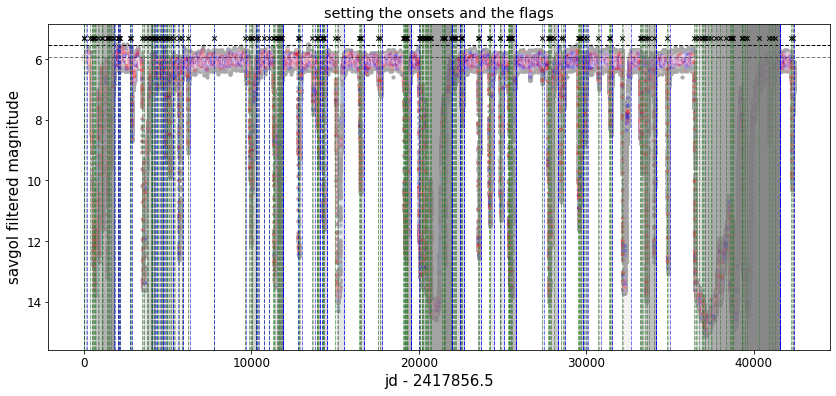

resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3
resetting decline flag to 3


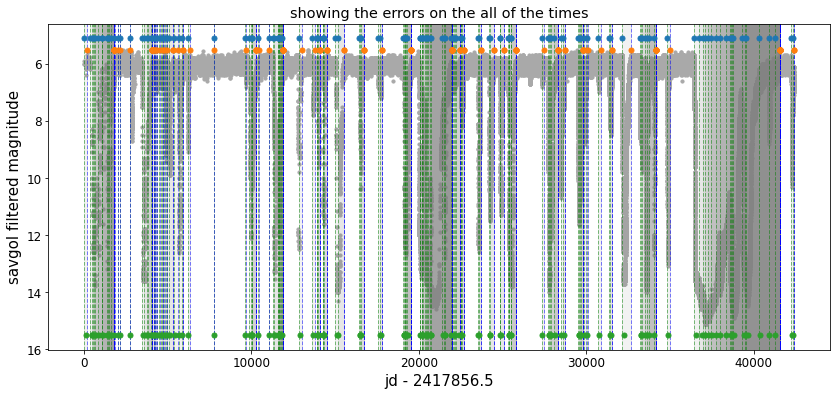

median max light: 5.8
mean max light: 5.796
min decline depth: 0.4
length of light curve: 42398.72917000018
sampling percent of light curve: 81.05
{'median_max': 5.8, 'mean_max': 5.796, 'min_depth': 0.4, 'baseline': 42398.72917000018, 'sampling': 81.05}


onset_time  onset_err_l  onset_err_r  onset_flag      end_time  \
0    2.417856e+06          NaN   101.429500         3.0  2.417874e+06   
1    2.417874e+06          NaN    95.426500         0.0  2.418023e+06   
2    2.418242e+06    41.558000    49.150000         0.0  2.419635e+06   
3    2.418336e+06    49.038000    31.427500         0.0  2.419635e+06   
4    2.418376e+06    24.935500    15.455000         0.0  2.419635e+06   
..            ...          ...          ...         ...           ...   
175  2.458739e+06     1.377410     0.513300         0.0  2.459385e+06   
176  2.458953e+06     0.742350     0.075700         3.0  2.459385e+06   
177  2.459125e+06     1.381055     0.626805         0.0  2.459385e+06   
178  2.460088e+06     1.010050     0.501350         0.0  2.460255e+06   
179  2.460175e+06     0.944100     0.515960         0.0  2.460255e+06   

     end_err_l  end_err_r  end_flag    depth_time  depth_err_l  depth_err_r  \
0          NaN   95.42650       0.0  2.417856e+06          NaN   101.429500   
1          NaN   28.00000       0.0  2.417984e+06          NaN    43.776500   
2     5.173500    5.39950       0.0  2.418316e+06    51.667500    20.950500   
3     5.173500    5.39950       0.0  2.418360e+06    19.859500    22.009000   
4     5.173500    5.39950       0.0  2.418422e+06     8.434500     7.454500   
..         ...        ...       ...           ...          ...          ...   
175   0.484030    1.00727       0.0  2.458770e+06     0.925000     0.072500   
176   0.484030    1.00727       0.0  2.458974e+06     0.795200     0.521450   
177   0.484030    1.00727       0.0  2.459127e+06     0.951055     0.547895   
178   3.986135        NaN       1.0  2.460113e+06     0.822900     0.629880   
179   3.986135        NaN       1.0  2.460185e+06     0.989900     1.018080   

     decline_depth  min_mag  sampling  
0              0.0      6.0     17.65  
1              0.5      6.4      3.33  
2              2.7      8.8     10.64  
3              2.1     10.4     19.51  
4              2.5     12.8     30.56  
..             ...      ...       ...  
175            2.3      8.6     93.49  
176            0.4      6.5    100.00  
177            0.7      6.7     96.55  
178            4.1     10.3    100.00  
179            0.6      7.4     95.06  

[180 rows x 14 columns]

In [392]:
rcb_frame = decline_detection(vband[vband['jd']-vband['jd'][0]>45000].reset_index(),
                              debug_mode=False,saturation_limit=0,decline_min_depth=0.4)
rcb_frame

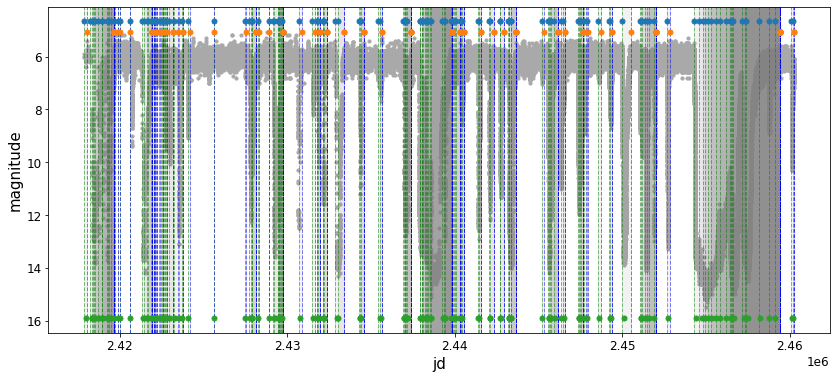

In [474]:
plt.figure(figsize=(14,6))
plt.scatter(rcb_band['jd'],rcb_band['mag'],
            s=10,color='darkgrey')

plt.errorbar(x=rcb_frame['onset_time'][np.asarray(rcb_frame['onset_flag']) != 3],
            y=np.full(len(rcb_frame['onset_time'][np.asarray(rcb_frame['onset_flag']) != 3]),np.min(rcb_band['mag']))-0.4,
             xerr=(rcb_frame['onset_err_l'][np.asarray(rcb_frame['onset_flag']) != 3],
                   rcb_frame['onset_err_r'][np.asarray(rcb_frame['onset_flag']) != 3]),fmt='o')

plt.errorbar(x=rcb_frame['end_time'][np.asarray(rcb_frame['onset_flag']) != 3],
            y=np.full(len(rcb_frame['end_time'][np.asarray(rcb_frame['onset_flag']) != 3]),np.min(rcb_band['mag']))-0,
             xerr=(rcb_frame['end_err_l'][np.asarray(rcb_frame['onset_flag']) != 3],
                   rcb_frame['end_err_r'][np.asarray(rcb_frame['onset_flag']) != 3]),fmt='o')

plt.errorbar(x=rcb_frame['depth_time'][np.asarray(rcb_frame['onset_flag']) != 3],
            y=np.full(len(rcb_frame['depth_time'][np.asarray(rcb_frame['onset_flag']) != 3]),np.max(rcb_band['mag']))+0.4,
             xerr=(rcb_frame['depth_err_l'][np.asarray(rcb_frame['onset_flag']) != 3],
                   rcb_frame['depth_err_r'][np.asarray(rcb_frame['onset_flag']) != 3]),fmt='o')


for onset_time in rcb_frame['onset_time'][np.asarray(rcb_frame['onset_flag']) != 3]:
    plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')

for end_time in rcb_frame['end_time'][np.asarray(rcb_frame['onset_flag']) != 3]:
    plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')

for i in range(0,len(rcb_frame['onset_time'])):
    if rcb_frame['onset_flag'][i] != 3:
        plt.axvspan(rcb_frame['onset_time'][i], rcb_frame['end_time'][i], alpha=0.1, color='grey')

plt.gca().invert_yaxis()
plt.xlabel('jd')
plt.ylabel('magnitude')
# plt.xlim(2440000,2450000)
# plt.xlim(left=2450000)
plt.show()

In [411]:
decline_mask = np.full(len(rcb_band['jd']),
                       True)
time = rcb_band['jd']
for i in range(0,len(rcb_frame['onset_time'])):
    if rcb_frame['onset_flag'][i] != 3:
        condition = np.logical_and(time > rcb_frame['onset_time'][i], time < rcb_frame['end_time'][i])
#         print(~condition)
        decline_mask = decline_mask & ~condition

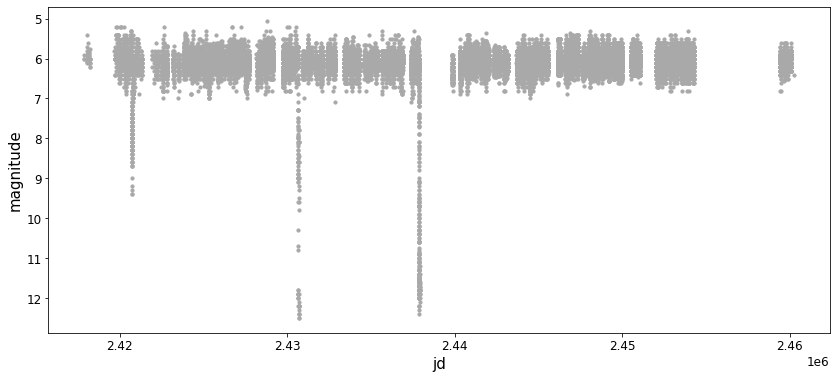

In [471]:
plt.figure(figsize=(14,6))
plt.scatter(rcb_band['jd'][decline_mask],rcb_band['mag'][decline_mask],
            s=10,color='darkgrey')
plt.gca().invert_yaxis()
plt.xlabel('jd')
plt.ylabel('magnitude')
# plt.xlim(2440000,2455000)
plt.show()

In [456]:
## some binning code that I had from elsewhere
bins = np.linspace(np.min(rcb_band['jd']), np.max(rcb_band['jd']), int(len(rcb_band)/40)) # 10 days
# bins = np.linspace(np.min(rcb_band['jd']), np.max(rcb_band['jd']), int(len(rcb_band)/20)) # 5 days
# bins = np.linspace(np.min(rcb_band['jd']), np.max(rcb_band['jd']), int(len(rcb_band)/10)) # 2 days
digitized = np.digitize(rcb_band['jd'], bins)
bin_means = [rcb_band['mag'][digitized == i].mean() for i in range(1, len(bins))]
bin1_lc_time = np.asarray(bins[:-1])
bin1_lc_flux = np.asarray(bin_means)

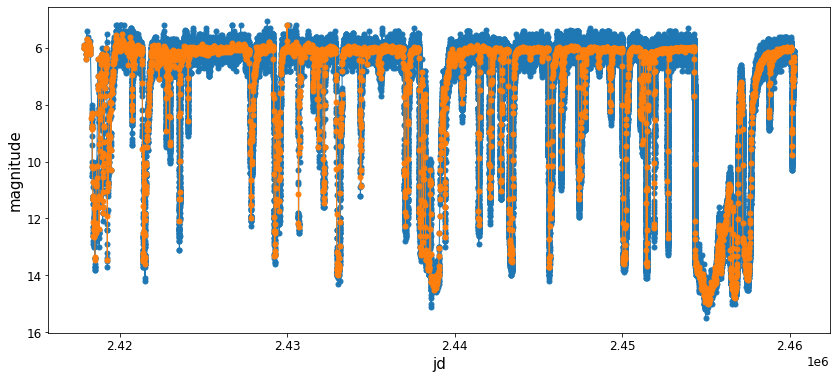

In [457]:
## checking that it looks right because I didn't write that binning code
plt.figure(figsize=(14,6))
plt.plot(rcb_band['jd'],rcb_band['mag'],marker='o')
plt.plot(bin1_lc_time,bin1_lc_flux,marker='o')
# plt.xlim(500,502)
plt.gca().invert_yaxis()
plt.xlabel('jd')
plt.ylabel('magnitude')
# plt.xlim(2440000,2455000)
# plt.xlim(2450000,2454000)
# plt.xlim(2453900,2454000)
# plt.xlim(2453900,2453910)
plt.show()

In [458]:
decline_mask_2 = np.full(len(bin1_lc_time),
                       True)
time = bin1_lc_time
for i in range(0,len(rcb_frame['onset_time'])):
    if rcb_frame['onset_flag'][i] != 3:
        condition = np.logical_and(time > rcb_frame['onset_time'][i], time < rcb_frame['end_time'][i])
#         print(~condition)
        decline_mask_2 = decline_mask_2 & ~condition

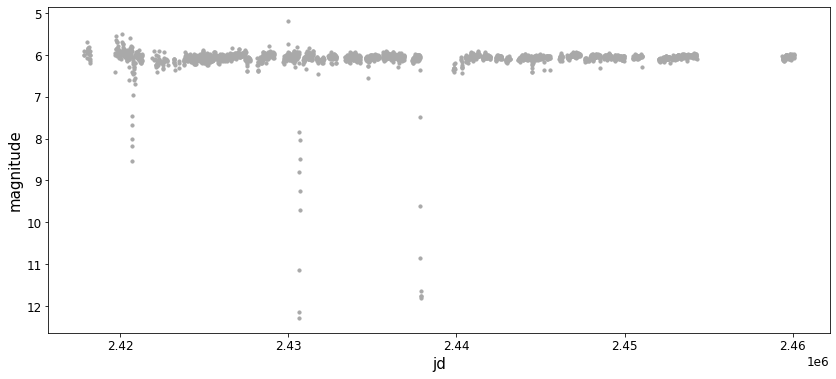

In [459]:
plt.figure(figsize=(14,6))
# plt.plot(rcb_band['jd'],rcb_band['mag'],marker='o')
# plt.plot(bin1_lc_time,bin1_lc_flux,marker='o')
plt.scatter(bin1_lc_time[decline_mask_2],bin1_lc_flux[decline_mask_2],
            s=10,color='darkgrey')
# plt.xlim(500,502)
plt.gca().invert_yaxis()
plt.xlabel('jd')
plt.ylabel('magnitude')
# plt.xlim(2440000,2455000)
# plt.xlim(2450000,2454000)
# plt.xlim(2453900,2454000)
# plt.xlim(2453900,2453910)
plt.show()

In [460]:
from astropy.stats import sigma_clip

clipped_flux = sigma_clip(bin1_lc_flux[decline_mask_2], sigma=3.5, maxiters=1)

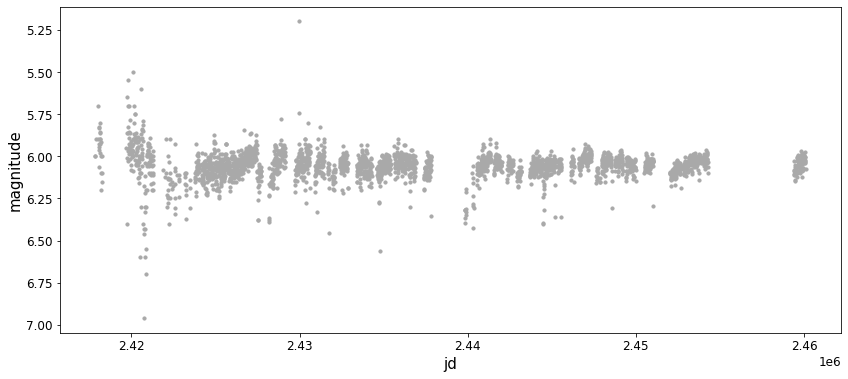

In [463]:
plt.figure(figsize=(14,6))
plt.scatter(bin1_lc_time[decline_mask_2],clipped_flux,
            s=10,color='darkgrey')
plt.gca().invert_yaxis()
plt.xlabel('jd')
plt.ylabel('magnitude')
# plt.xlim(2440000,2455000)
# plt.xlim(2450000,2454000)
# plt.xlim(2453900,2454000)
# plt.xlim(2453900,2453910)
plt.show()

In [465]:
freq, amp = calc_lomb_scargle(bin1_lc_time[decline_mask_2],clipped_flux)
freq = 11.574/freq

In [470]:
## argh
amp

array([nan, nan, nan, ..., nan, nan, nan])

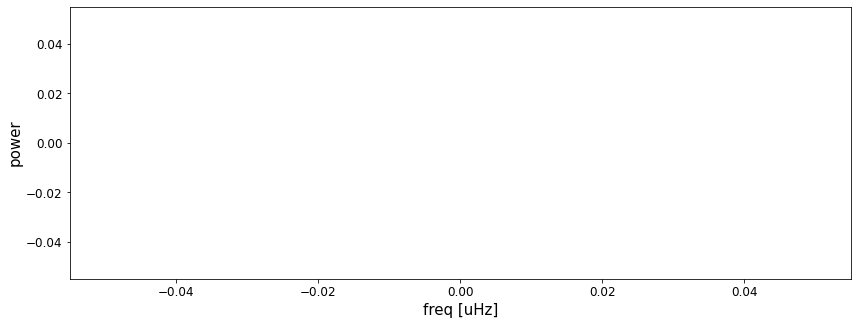

In [468]:
plt.figure(figsize=(14,5))
plt.plot(freq,amp**2)
# plt.axvline(11.574/84.5,color='k',alpha=0.5)
# plt.axvline(11.574/80.2,color='k',alpha=0.5)
# plt.axvline(0.08,color='k')
plt.xlabel('freq [uHz]')
plt.ylabel('power')
# plt.xlim(10**-1,2e-1)
# plt.ylim(-0.1e8,0.6e8)
# plt.xlim(right=0.5)
plt.show()